# Tutorial 3 : Training Spiking Neural Networks using BPTT

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**: Ugurcan Cakal, Hannah Bos, Saeid Haghighatshoar

**Estimated timing**: 30 minutes

So far we have investigated the Integrate and Fire (IF) neuron model and trained a Convolutional Neural Network (CNN) on a body posture classification task to be converted into a Spiking Neural Network (SNN). In this tutorial, we will investigate and optimize the firing rate response of a simple spiking neural network. We will define a single neuron with a single input channel, then measure the mean firing rate of the spiking neuron throughout the simulation duration. Specifically, we will explore:

* How to build an SNN using Rockpool torch-backend Leaky Integrate and Fire (LIF) model namely `LIFTorch`
* How to optimize parameters of an SNNs directly using Back Propagation Through Time (BPTT)
* Why gradients vanish at spikes and how the problem can be alleviated using surrogate gradients

Below there is a diagram visualizing the model of interest.

<img src="figures/network.png" width="1024">

---
# Setup

In [2]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
import numpy as np
from tqdm import tqdm

# Torch Imports
import torch
from torch.nn import MSELoss
from torch.optim import Adam

# Rockpool Imports
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.modules.torch.lif_torch import StepPWL
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# Tutorial Utils
from utils import plot_LIF_record, poisson_spike_train, RateReadout, plot_signal, plot_raster

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

Could not import package: No module named 'iaf_nest'


### Data Generation

### Plotting

### Readout

---
## Section 1: Model Implementation
*Estimated timing: 5 minutes*

For the task, we will use 3 Rockpool modules in sequential combination. 

`LinearTorch`, `LIFTorch`, and `RateReadout`.

Let's deep dive into Rockpool implementation and construct the model.

### Section 1.1 : LinearTorch

Linear layer stores an input weight matrix. It's analogous to `torch.nn.Linear`, and applies a linear transformation to the incoming data. Then pass the results to the next layer.    

* $S_{in}^{f}(t) = S_{in}^{b}(t) \cdot W_{in}^{T} + b $

| **TERM**          | **DEFINITION**                                                                        |
|------------------	|-------------------------------------------------------------------------------------- |
| $S_{in}^{f}(t)$   | A float vector containing weighed spikes for each input channel                       |
| $S_{in}^{b}(t)$   | A binary vector containing ones for each input channel that emits a spike at time $t$ |
| $W_{in}$     	    | An input weight matrix                                                                |
| $b$     	        | linear bias                                                                           |

<img src="figures/linear_trans.png" width="1024">

In [3]:
# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    weight=torch.tensor([[0.02]]),
    has_bias=False,
)

### Section 1.2 : LIFTorch
LIF layer calculates the neuron dynamics and produces a spike train output. It's analogous to activation functions widely used in the machine learning field, like `torch.nn.ReLU`. However, the difference is that in LIF neurons, the output does not depend only on the instantaneous inputs. The neuron does have an internal state $V_{mem}(t)$ that would affect its output and include explicit temporal dynamics. The state does not only changes in the presence of spike events, but it also evolves in the absence of input. This situation introduces some subtle differences in how inputs, states, and outputs are treated. `LIFTorch` module implements the state update equations below.

1. As first step it updates the synaptic current input $I_{syn}$
    * $I_{syn}(t+1) = \left( I_{syn}(t) + S_{in}(t) + \underbrace{S_{rec}(t) \cdot W_{rec}}_{I_{rec}} \right) \cdot \underbrace{\text{exp} \left( - \dfrac{dt}{\tau_{syn}} \right)}_{\text{leakage}} $

| **TERM**          | **DEFINITION**                                                                     |
|------------------	|------------------------------------------------------------------------------------|
| $S_{rec}(t)$     	| A vector containing $1$ for each neuron that emitted a spike in the last time-step |
| $W_{rec}$     	| A recurrent weight matrix                                                          |
| $dt$             	| discrete timestep                                                                  |
| $\tau_{syn}$     	| synaptic time constant                                                             |

<img src="figures/exp_decay2.png" width="1024">

2. As a next step it calculates the membrane potential $V_{mem}$
    * $V_{mem}(t+1) = \left( V_{mem}(t) + I_{syn}(t) + I_b + \sigma \zeta(t) \right)  \cdot \text{exp} \left( - \dfrac{dt}{\tau_{mem}} \right)$

| **TERM**          | **DEFINITION**                                          |
|------------------	|-------------------------------------------------------- |
| $I_b$          	| bias current injection to the neruons                   |
| $\sigma\zeta(t)$ 	| A Wiener noise process with standard deviation $\sigma$ |
| $\tau_{mem}$     	| membrane time constant                                  |


3. When the membrane potential for neuron $j$, $V_{mem, j}$ exceeds the threshold voltage $V_{thr}$, then the neuron emits a spike. The spiking neuron subtracts its own threshold on reset.

* $V_{mem, j} > V_{thr} \rightarrow S_{rec,j} = 1$
* $V_{mem, j} = V_{mem, j} - V_{thr}$

<img src="figures/membrane_potential.png" width="1024">

Neurons therefore share a common resting potential of $0$, have individual firing thresholds, and perform subtractive reset of $-V_{thr}$.


In [4]:
# --- LIF Layer --- #
dt = 1e-3
lif = LIFTorch(
    shape=(1, 1),
    tau_mem=Constant(0.03),
    tau_syn=Constant(0.01),
    bias=Constant(0.0),
    threshold=Constant(1.0),
    noise_std = 0.0,
    spike_generation_fn=StepPWL,
    dt=dt,
)

### Section 1.3: RateReadout
Rate Readout layer is a custom `TorchModule` extension that is implemented specifically for this task. It stands for measuring the firing rate of the given duration.

* $r = \dfrac{\sum_{t=0}^{T} S_{rec}}{T}$

| **TERM**          | **DEFINITION**             |
|------------------	|----------------------------|
| $r$ 	            | firing rates of the neuron |
| $T$           	| simulation duraiton        |

In [6]:
# --- Readout Layer --- #
readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

## Section 2: Model Investigation

In this section, simulating the untrained network with random spike train, we will observe the intermedite steps, the evolution of the states through time

### Section 2.1 : Generate Input Spike Train

In order to observe the behaivor of the neuron and the intermeditate steps in the network, a poisson spike train with 200 Hz mean firing rate is generated. 

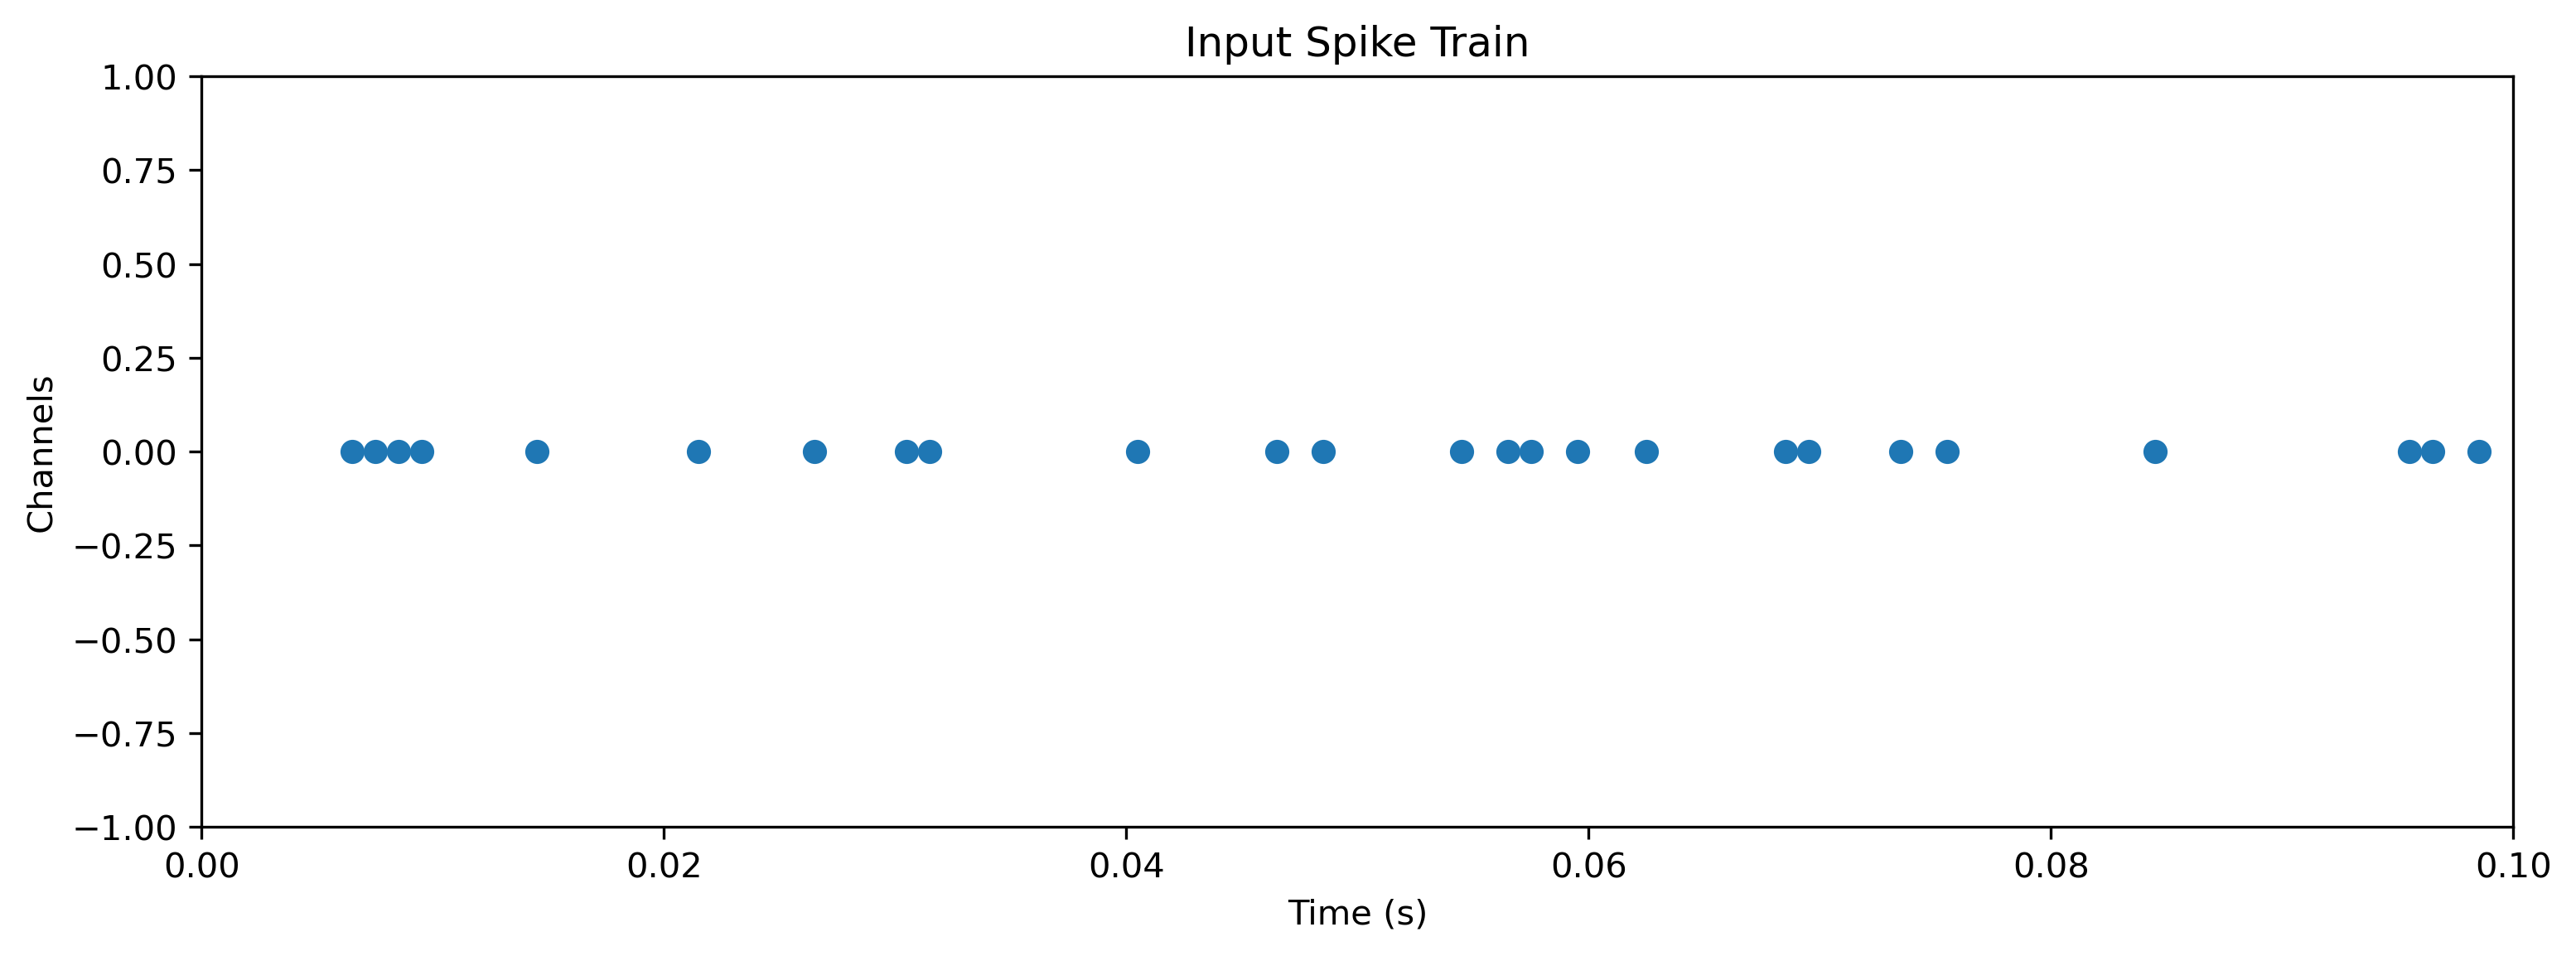

In [7]:
spike_ts = poisson_spike_train(duration=100e-3, rate=200.0, dt=dt, seed=2022)
plot_raster(spike_ts, "Input Spike Train", dt)

In [ ]:
# Run!
model.reset_state()
rate_out, state, record_dict = model(spike_ts, record = True)

In [10]:
# [] TODO : Explore the output of the model

### Section 2.2 Observe State Evolution Through Time

First of all, input layer makes a linear transformation of the spike train

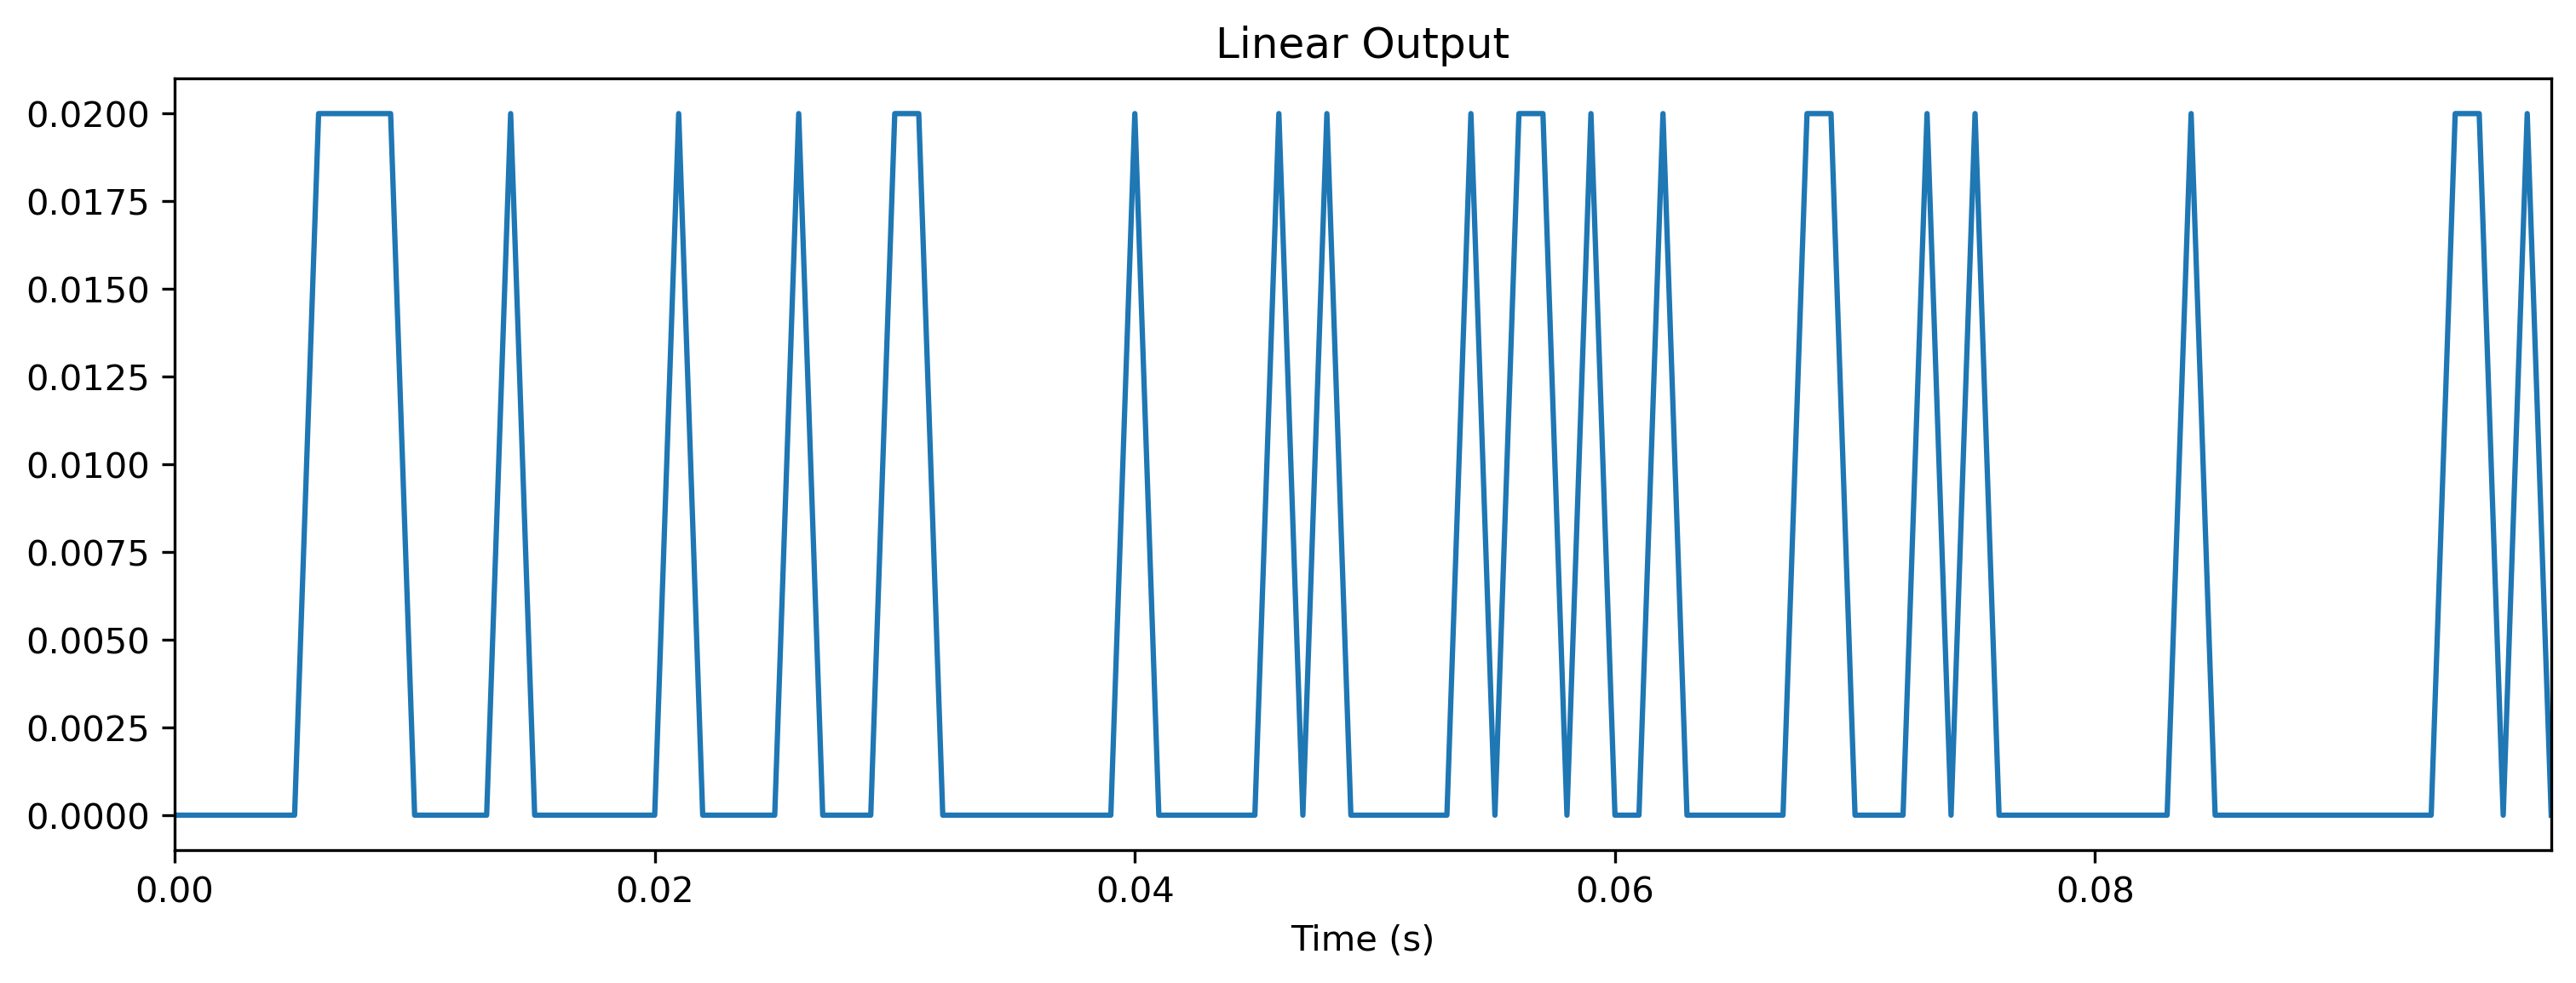

In [5]:
plot_signal(record_dict["0_LinearTorch_output"], "Linear Output", "", dt)

LIF layer computes the dynamics

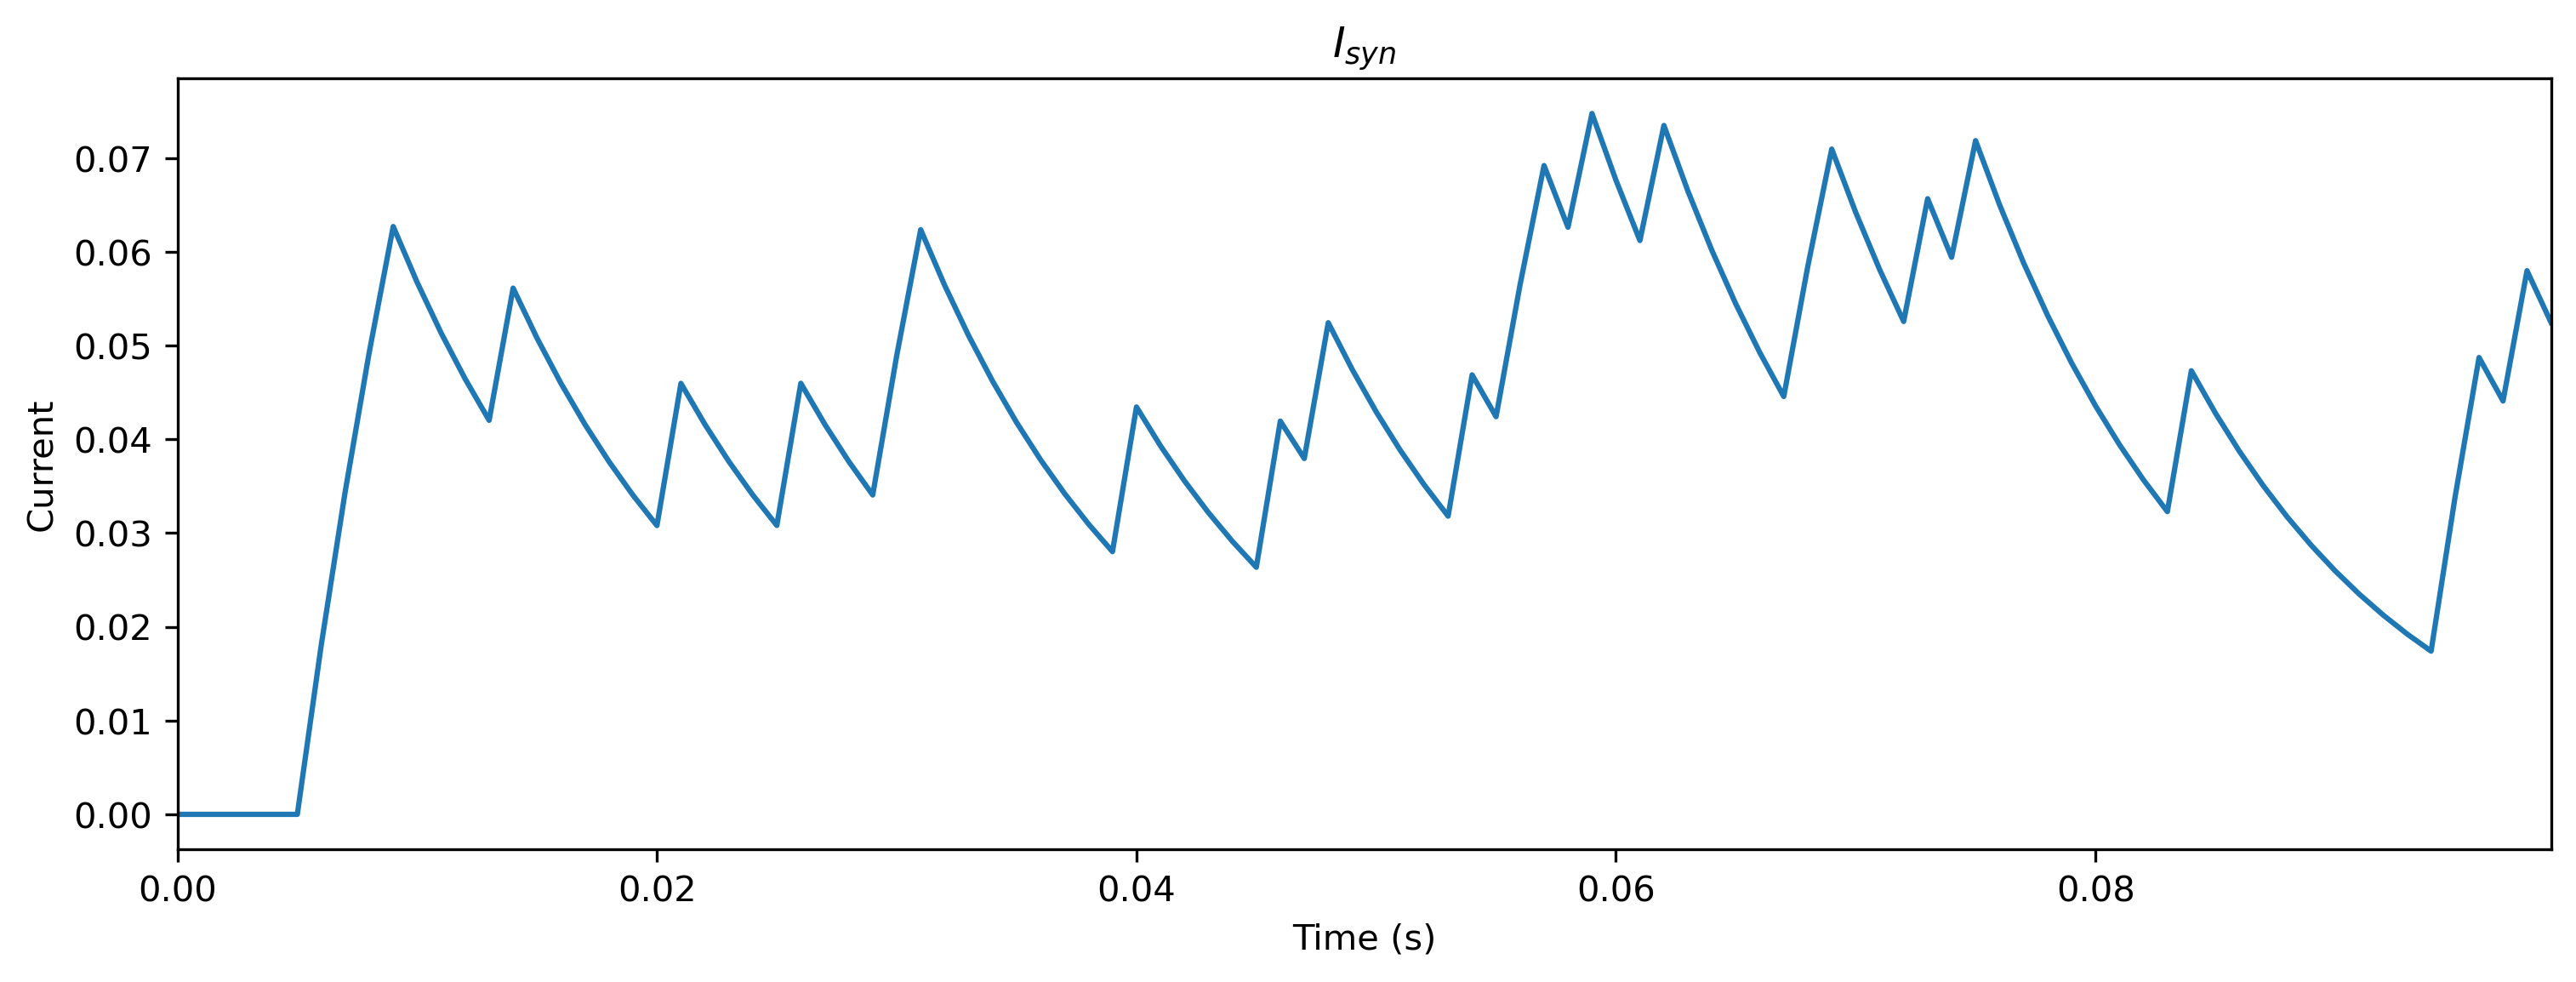

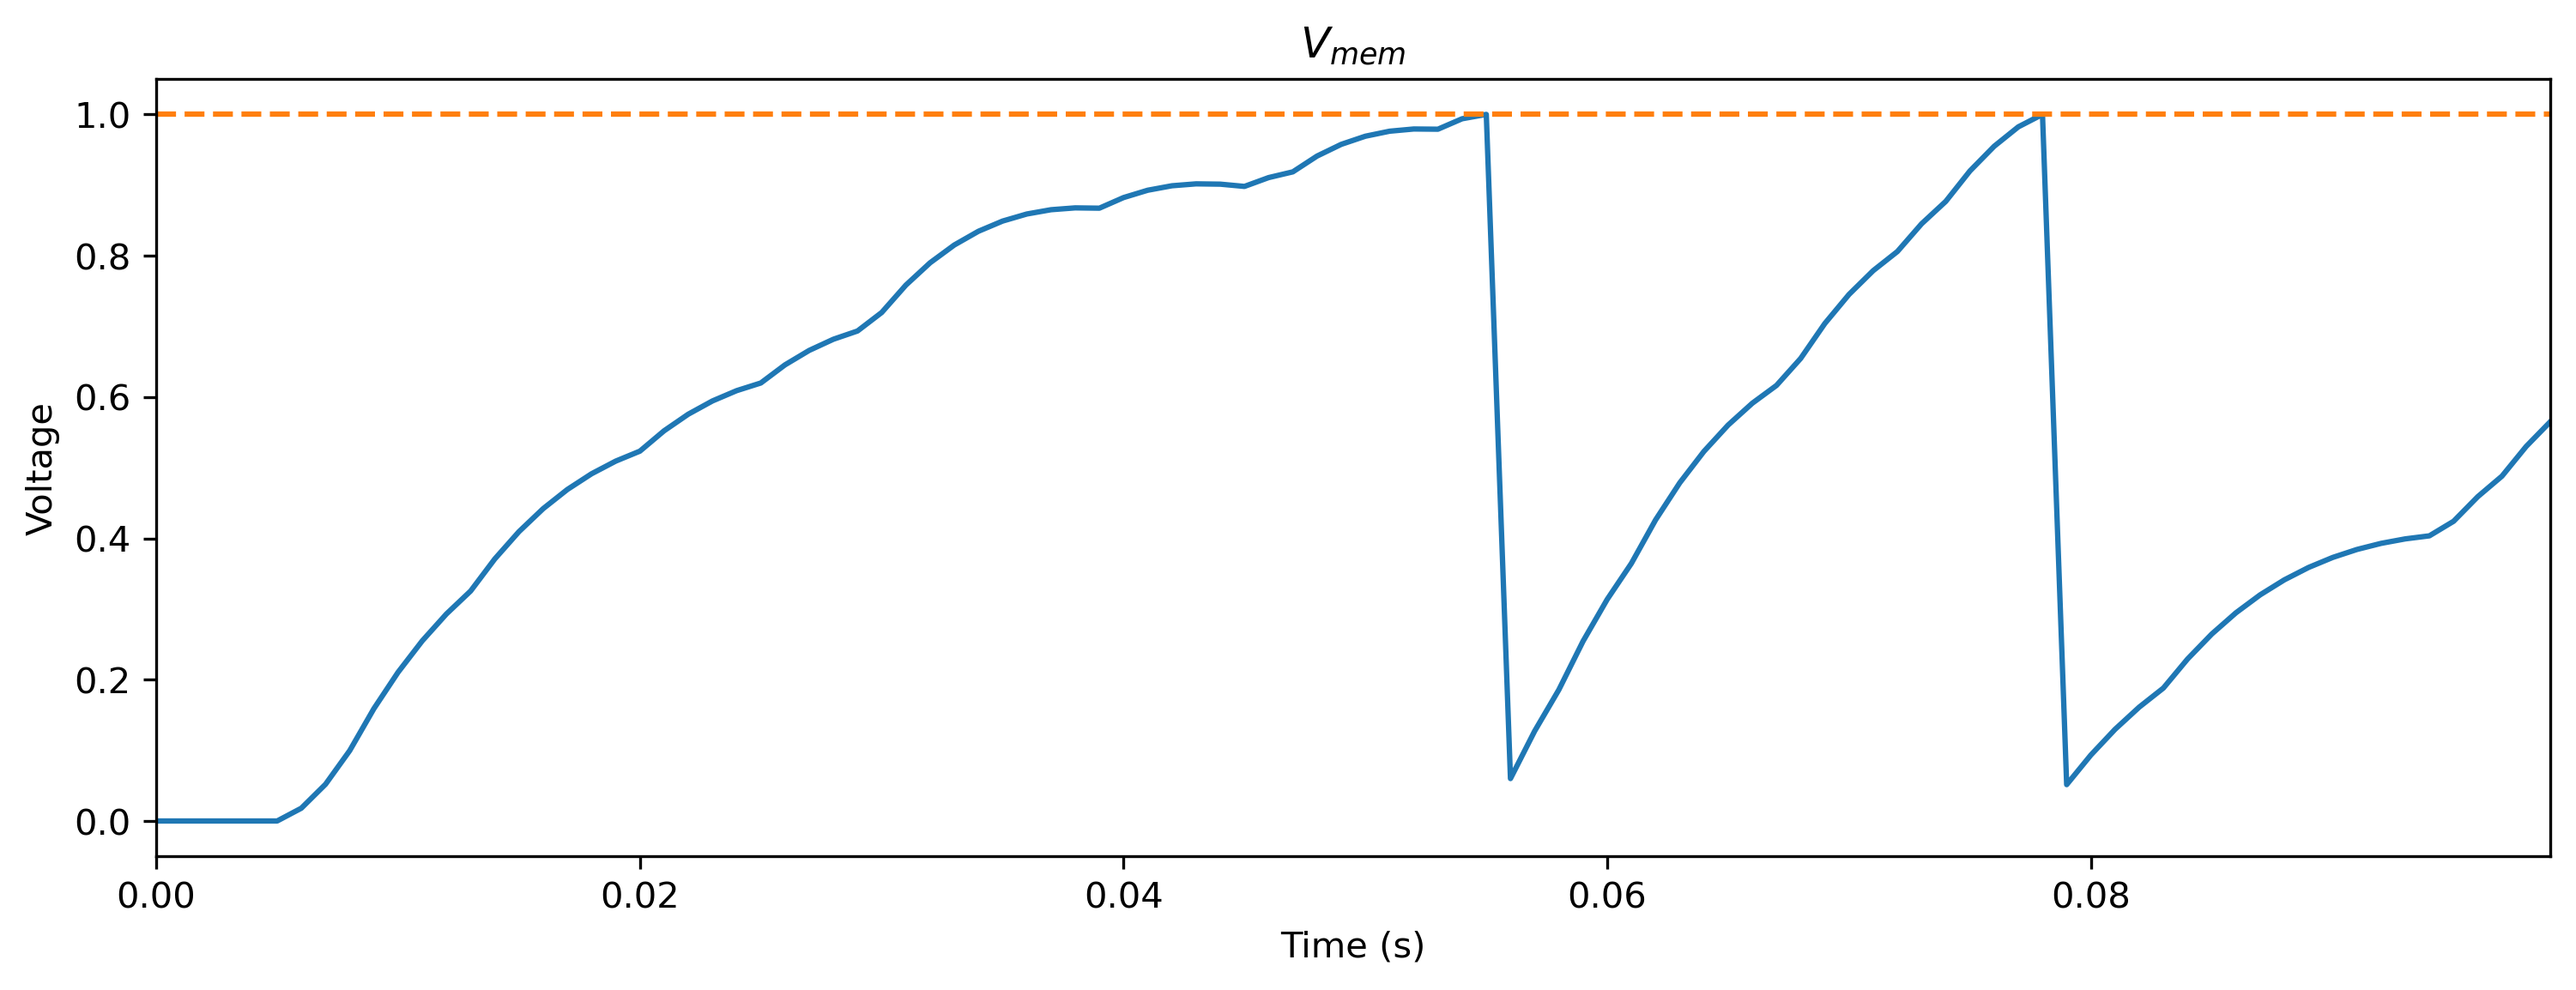

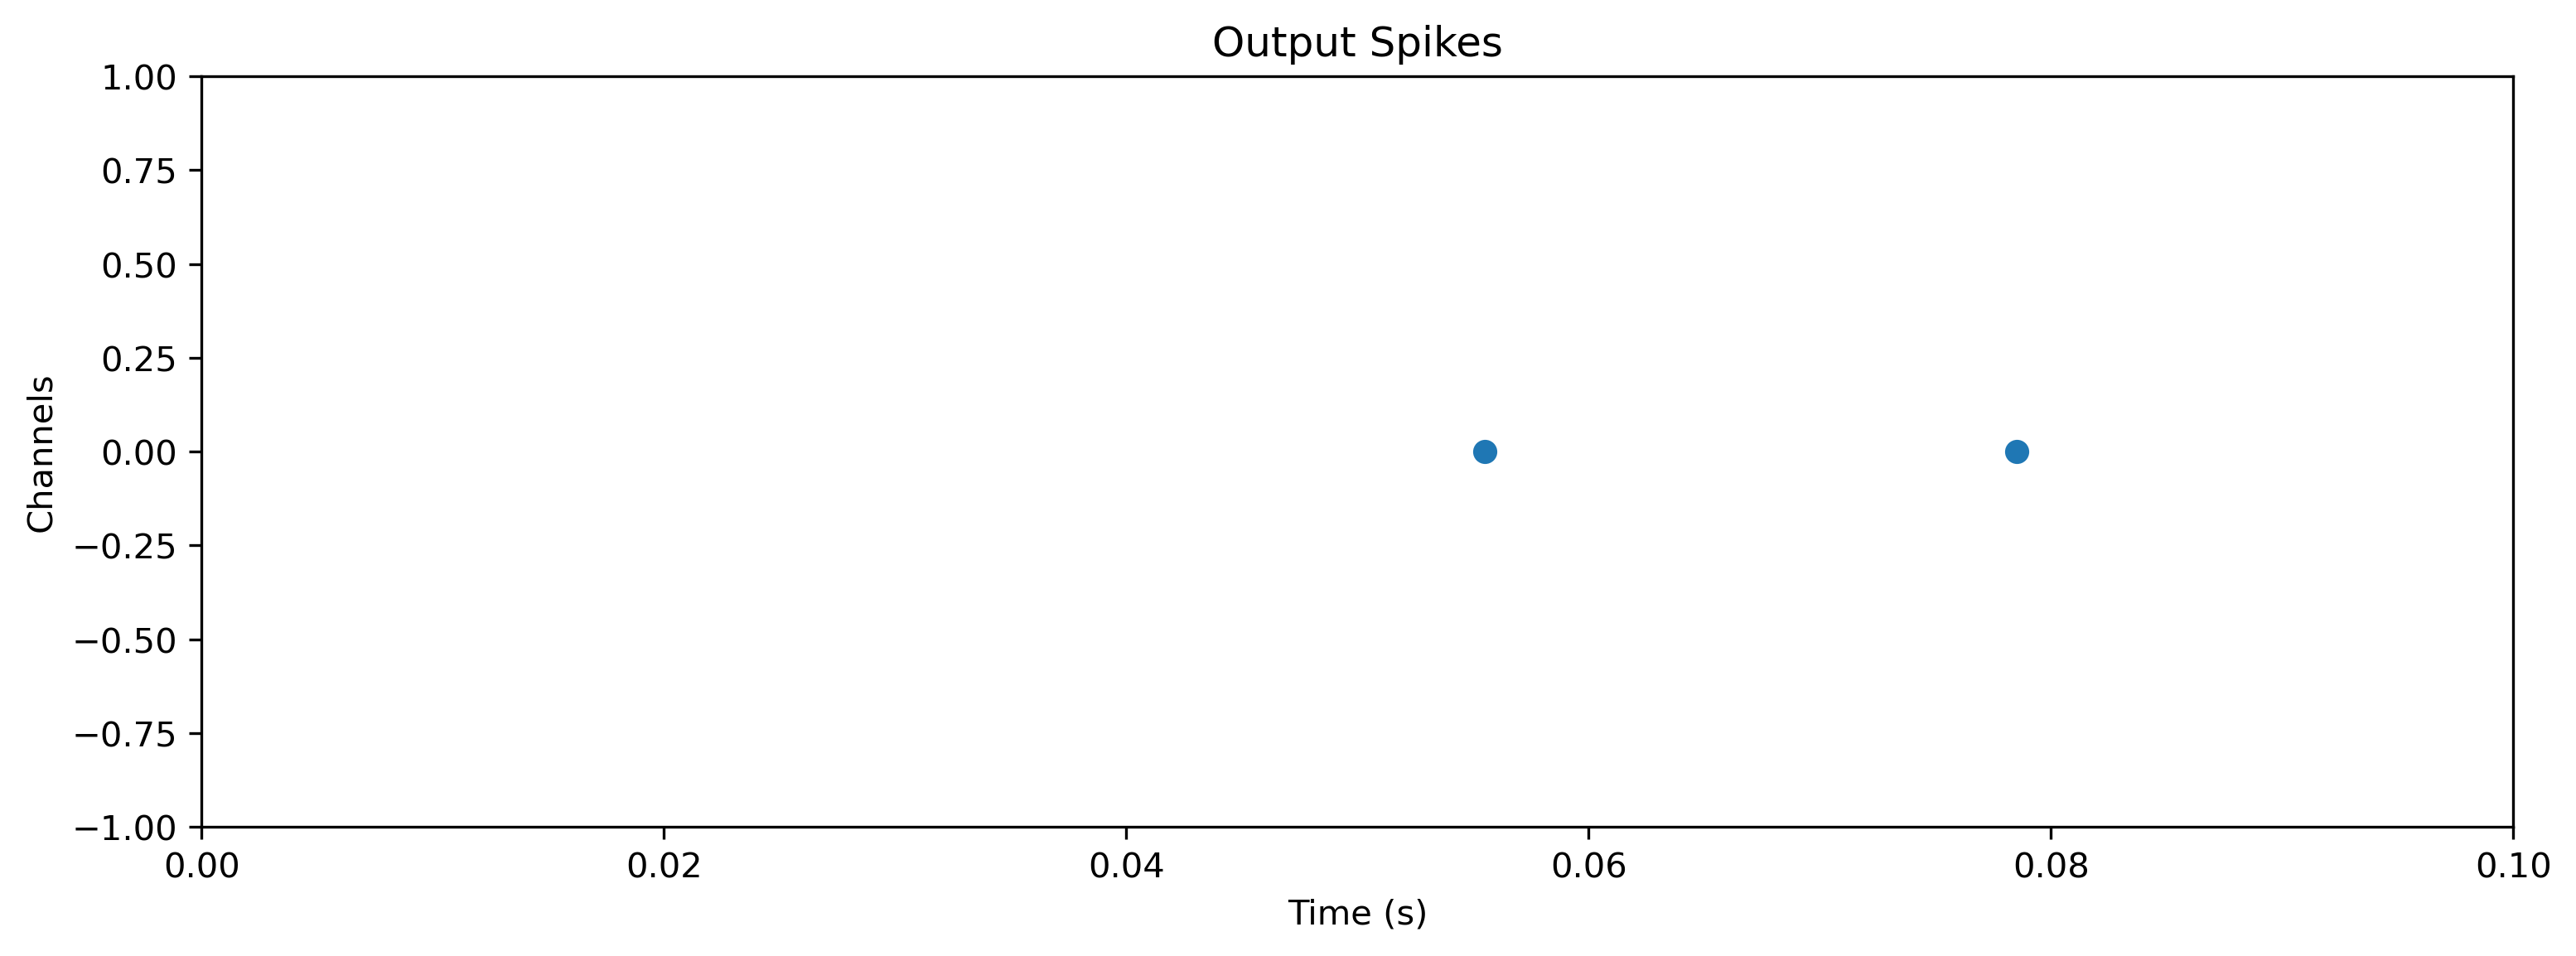

In [6]:
plot_LIF_record(record_dict['1_LIFTorch'], threshold=1.0)

2 spikes in 100 ms makes 20 Hz

In [7]:
print(rate_out)

tensor(20., grad_fn=<DivBackward0>)


---
## Section 3: Define the Optimization Task

We want the network to express a certain firing rate

In [8]:
target = torch.tensor(50.0)

### Loss Function

Here we're using mean square error (MSE) loss. 

MSE Loss : $ l = (r - \hat{r})^ 2 $

Let's investigate the loss function with respect to different rate readings

In [9]:
crit = MSELoss()
loss_trace = []

# Sweep over the rate values
R = np.linspace(0, target.item()*2, 100)
for _r in R:
    _loss = crit(torch.tensor(_r), target)
    loss_trace.append(_loss)

We see that the loss exponentially increases while the rate wander away from the target point

Text(0.5, 0, 'Firing rate (Hz)')

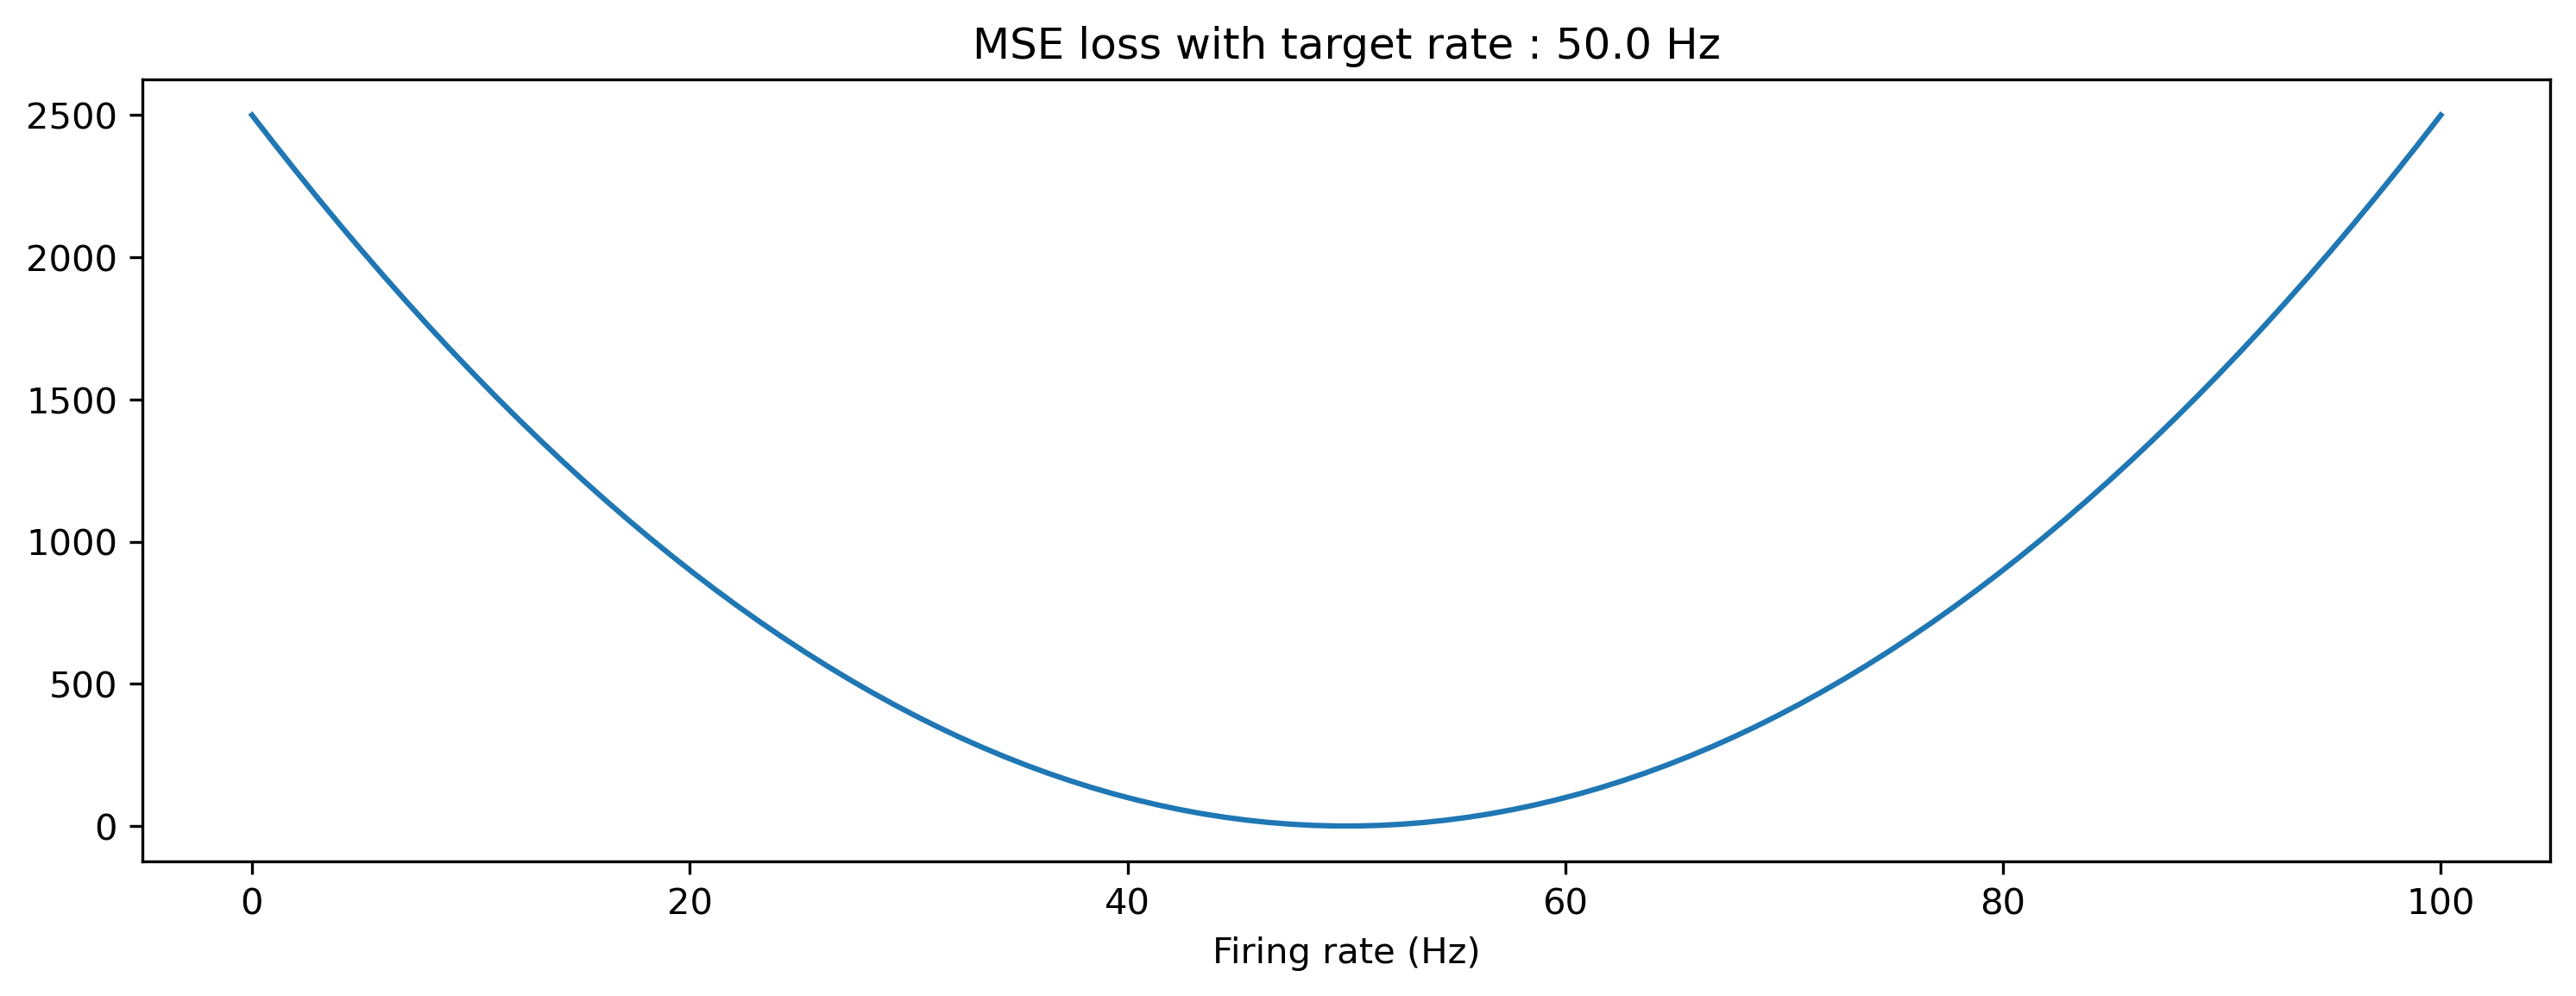

In [10]:
plt.figure()
plt.plot(R, loss_trace)
plt.title(f"MSE loss with target rate : {target.item()} Hz")
plt.xlabel("Firing rate (Hz)")

However, since the output of the `LIFTorch` is actually number of spikes, and we're counting the number of spikes to measure the firing rate, naturally, we would not be able to achieve any firing rate we want. Let's look at what can we have

Text(0.5, 1.0, 'Firing Rate with respect to number of spikes')

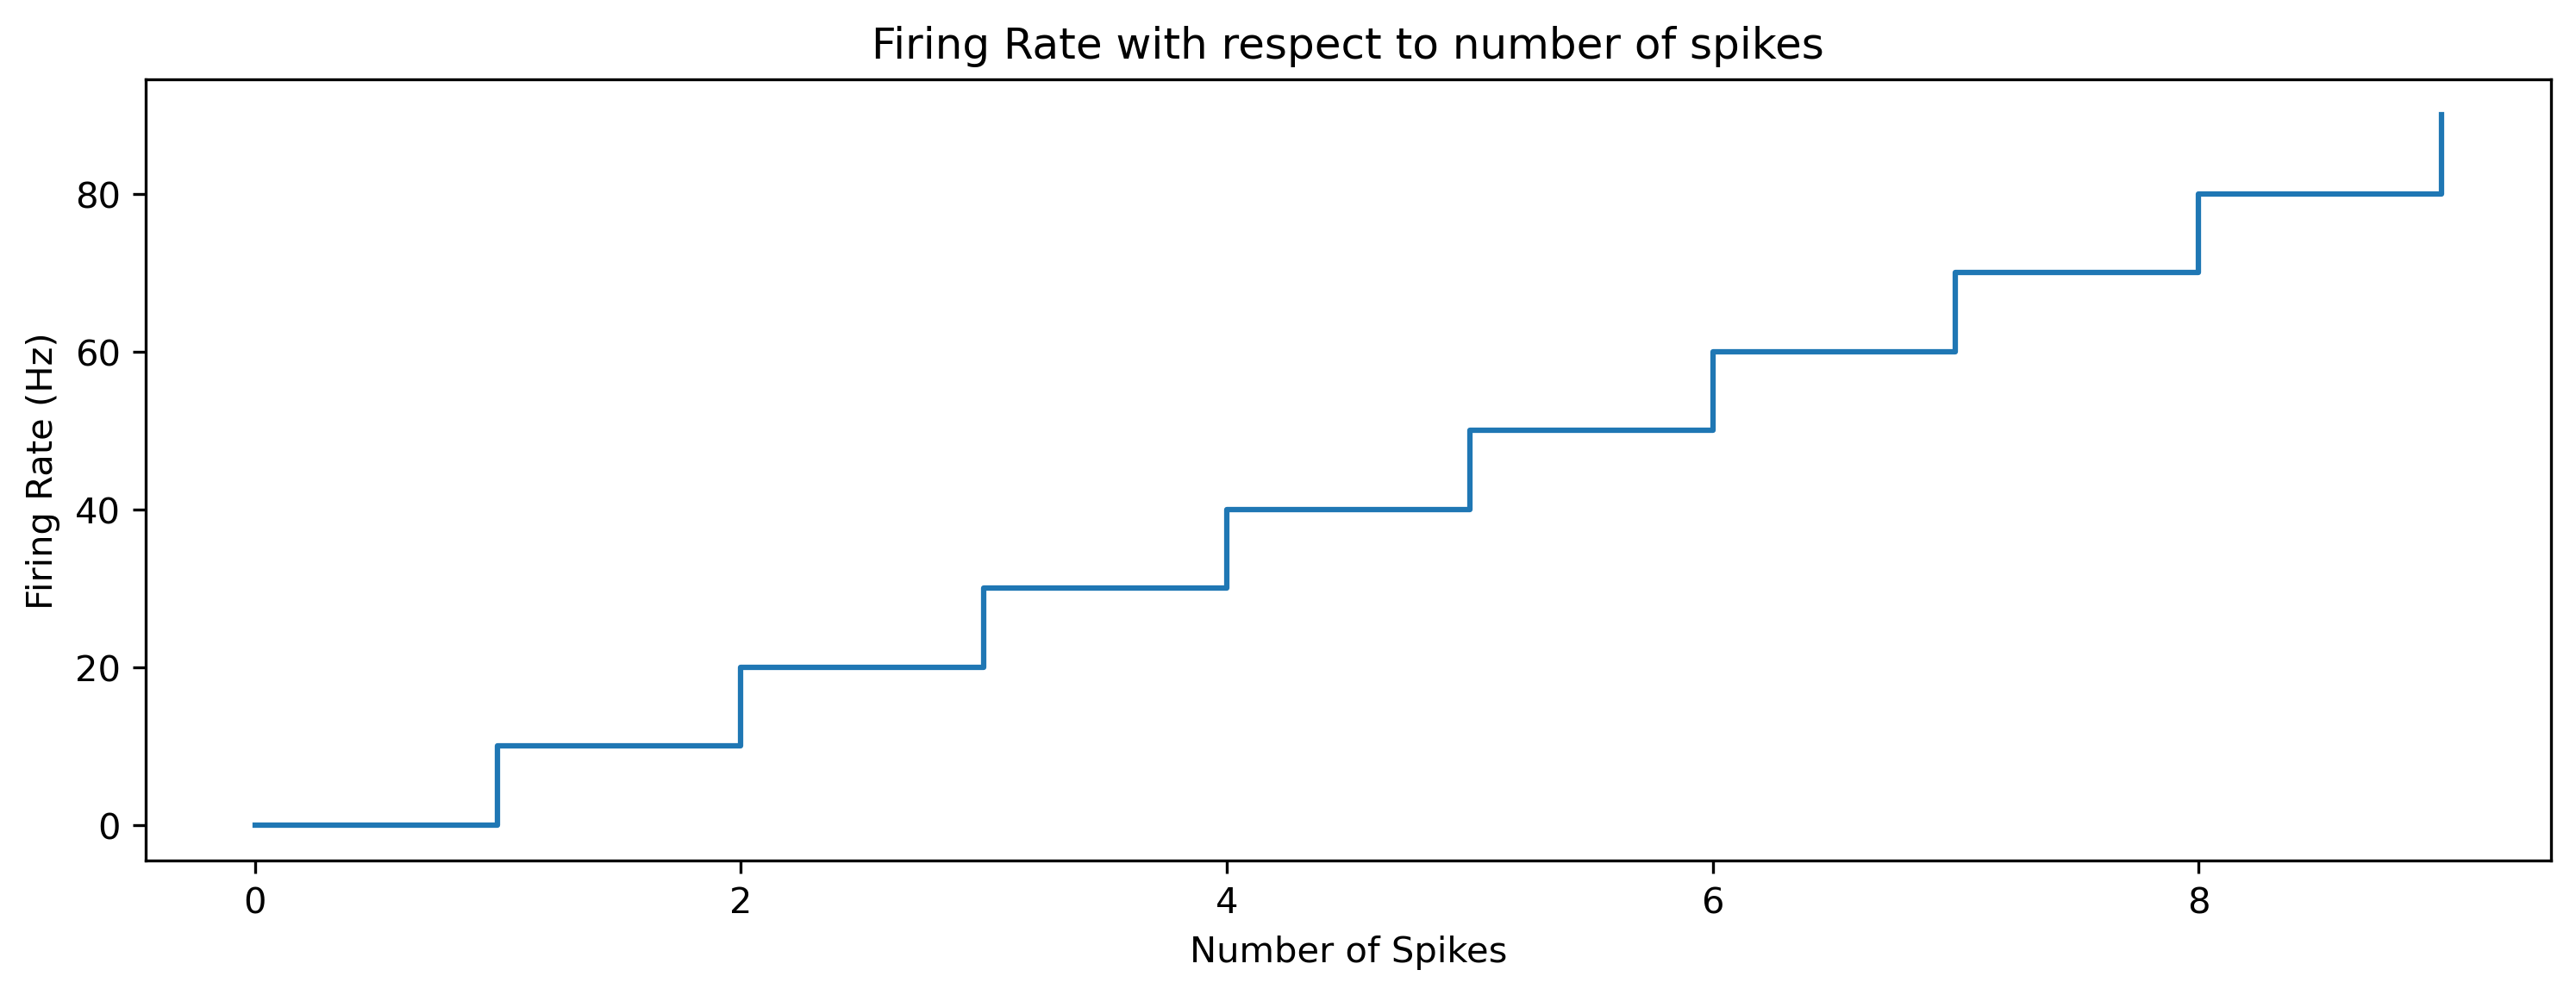

In [11]:
number_of_spikes = np.arange(0, 10, 1)
duration = 100e-3
firing_rates = number_of_spikes / duration

plt.step(number_of_spikes, firing_rates, where='post')
plt.xlabel("Number of Spikes")
plt.ylabel("Firing Rate (Hz)")
plt.title("Firing Rate with respect to number of spikes")

This problem naturally occurs using spiking neurons. In ANNs, there is not such problem because the the input and output signals of the neruons are continuous and differentiable.

Incremental steps would not be 1 with ANs.

<img src="figures/ann_snn.png" width="1024">

This situation changes the way we optimize. In order to see how different it is, let's investigate the loss surface with respect to weight parameter, that is the only trainable in our task.

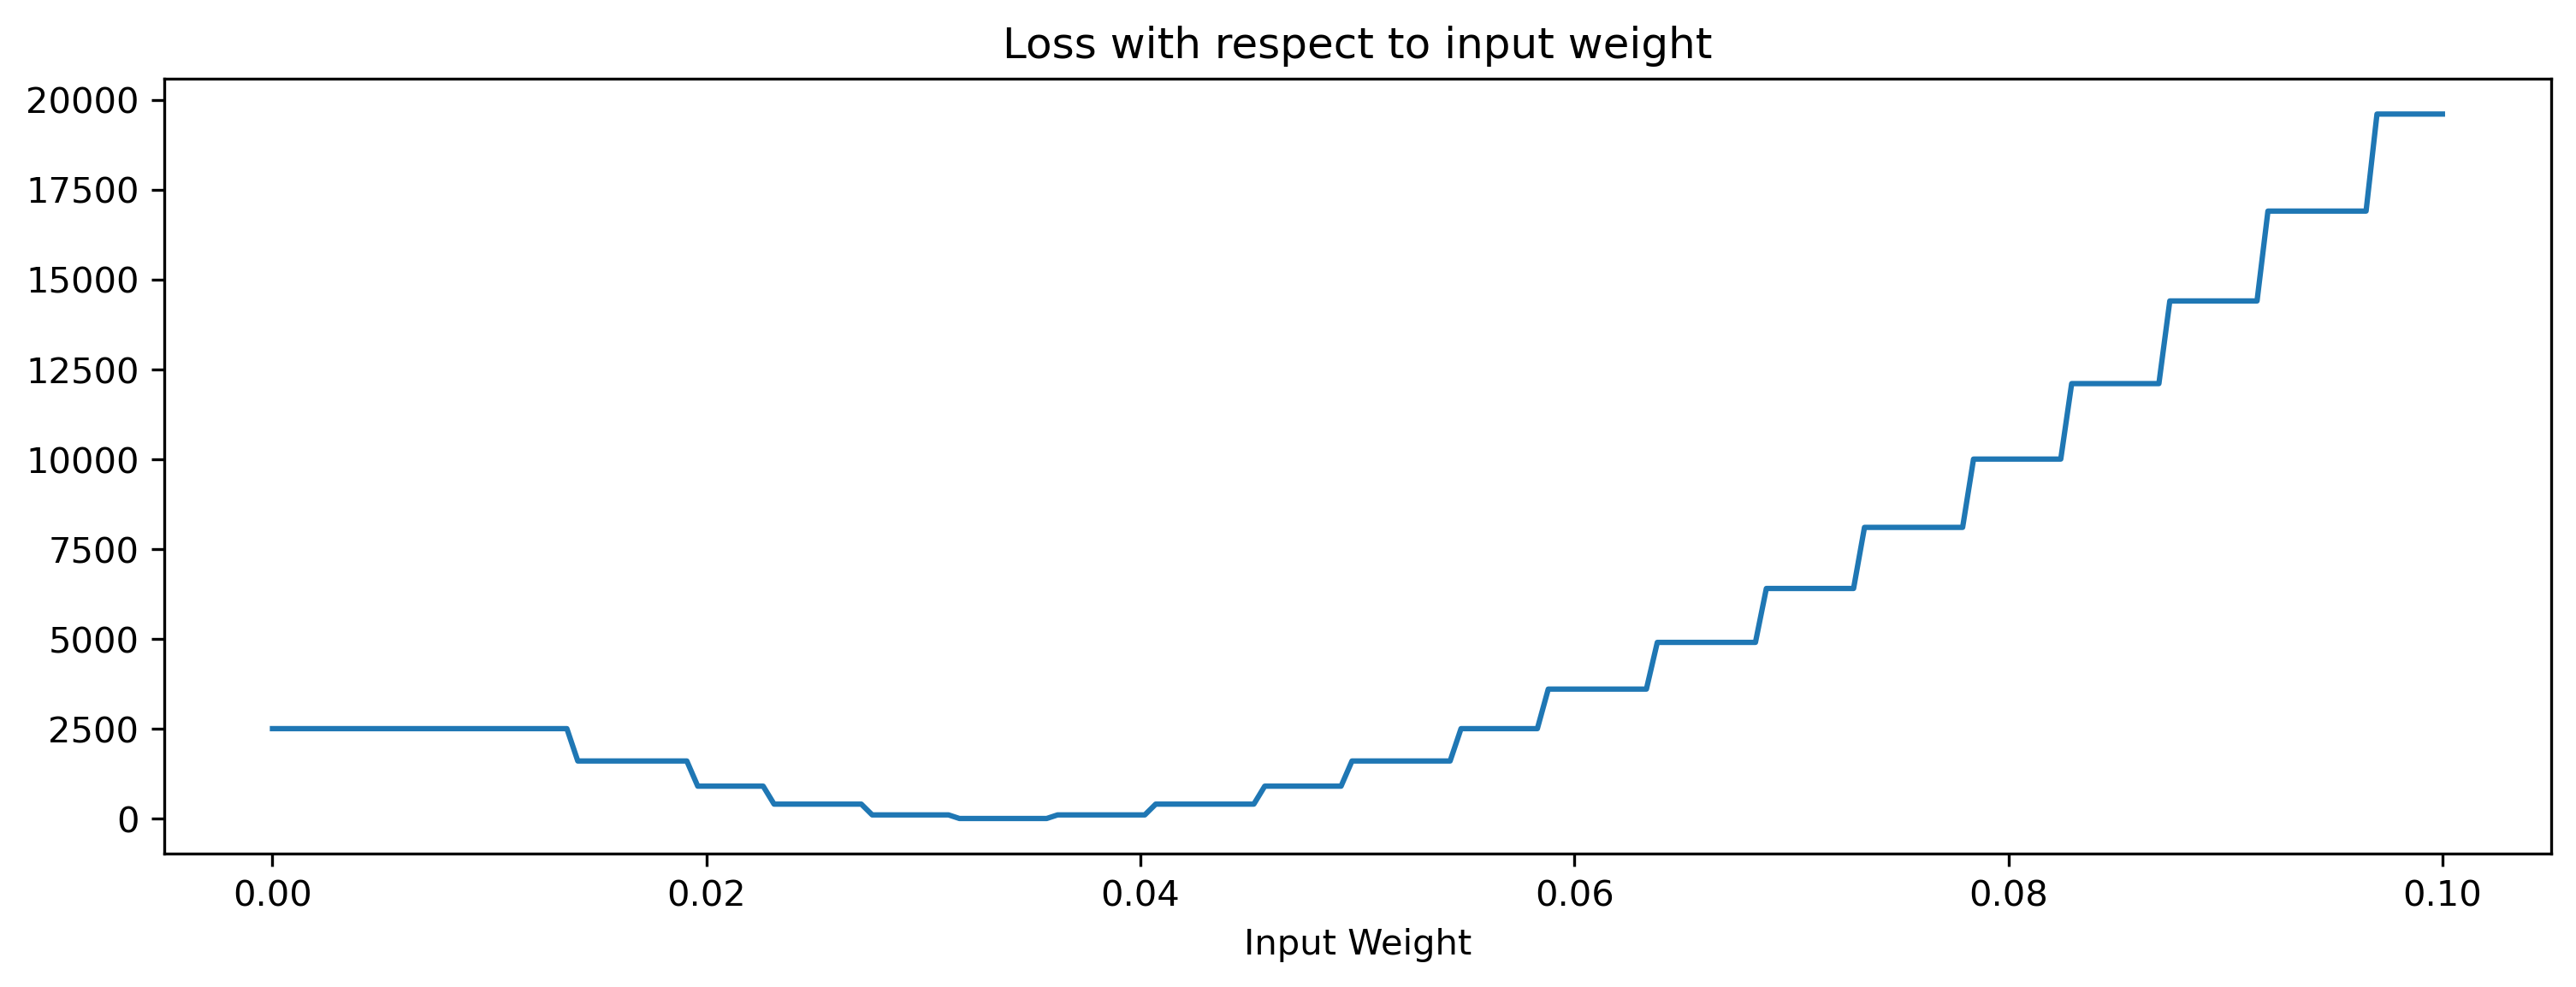

In [12]:
loss_trace = []
grad_trace = []
rate_trace = []

W = np.linspace(0, .1, 200, dtype=np.float32)

# Sweep over the weights
for w in W:
    # Redefine the model with a different input weight
    lin = LinearTorch((1, 1), weight = torch.tensor([[w]]), has_bias=False)
    model = Sequential(lin, lif, readout)

    # Simulate the network exactly with the same input
    model.reset_state()
    out, _, _ = model.evolve(spike_ts, record=True)
    rate_trace.append(out.item())
    
    # Calculate and record the loss
    loss = crit(target, out)
    loss_trace.append(loss.item())

    # Error backpropagation
    # loss -> readout -> lif -> linear         
    loss.backward()    
    grad_trace.append(model[0].weight.grad.item())

# Plot
plt.figure()
plt.plot(W, loss_trace)
plt.title("Loss with respect to input weight")
plt.xlabel("Input Weight");

If we want to apply a gradient based optimization technique to this problem, the process is in general

1. Initialize the weight with a random value
2. Compute the gradient of the loss with respect to weight
3. Slightly move to the opposite direction to the gradient
4. Repeat this until the process converges, and minimum loss achieved

However, you can see from the loss surface that gradients are 0 almost everywhere. Now let's investigate why this happens and how to overcome this problem.

<img src="figures/gradient_descent2.png" width="480">

It's not the end of the world! There are several ways to overcome this, we will investigate a popular one : surrogate gradients!

---
## Section 3: Surrogate Gradients

<img src="figures/surrogate_neuron.png" width="1024">

*Figure obtained from https://medium.com/neuromorphic-intelligence/putting-the-neural-back-into-networks-7a70bd267610*
 
In surrogate gradient method, the forward pass through a spiking neuron (top) uses a discontinuous spike generation function. The backwards pass (orange) uses a surrogate neuron (bottom, dashed); both neurons share a common weight w. The error x*-y is computed based on the surrogate output, and used to compute an error gradient with respect to the weights, $\nabla w$.

In `LIFTorch` neuron, if the membrane potential $V_{mem}$ is above a threshold $V_{th}$, the neuron produces a spike event on the output. It uses a Heaviside function in the forward pass.

$y = H(V_{mem}, V_{th}) = V_{mem} > V_{th}$

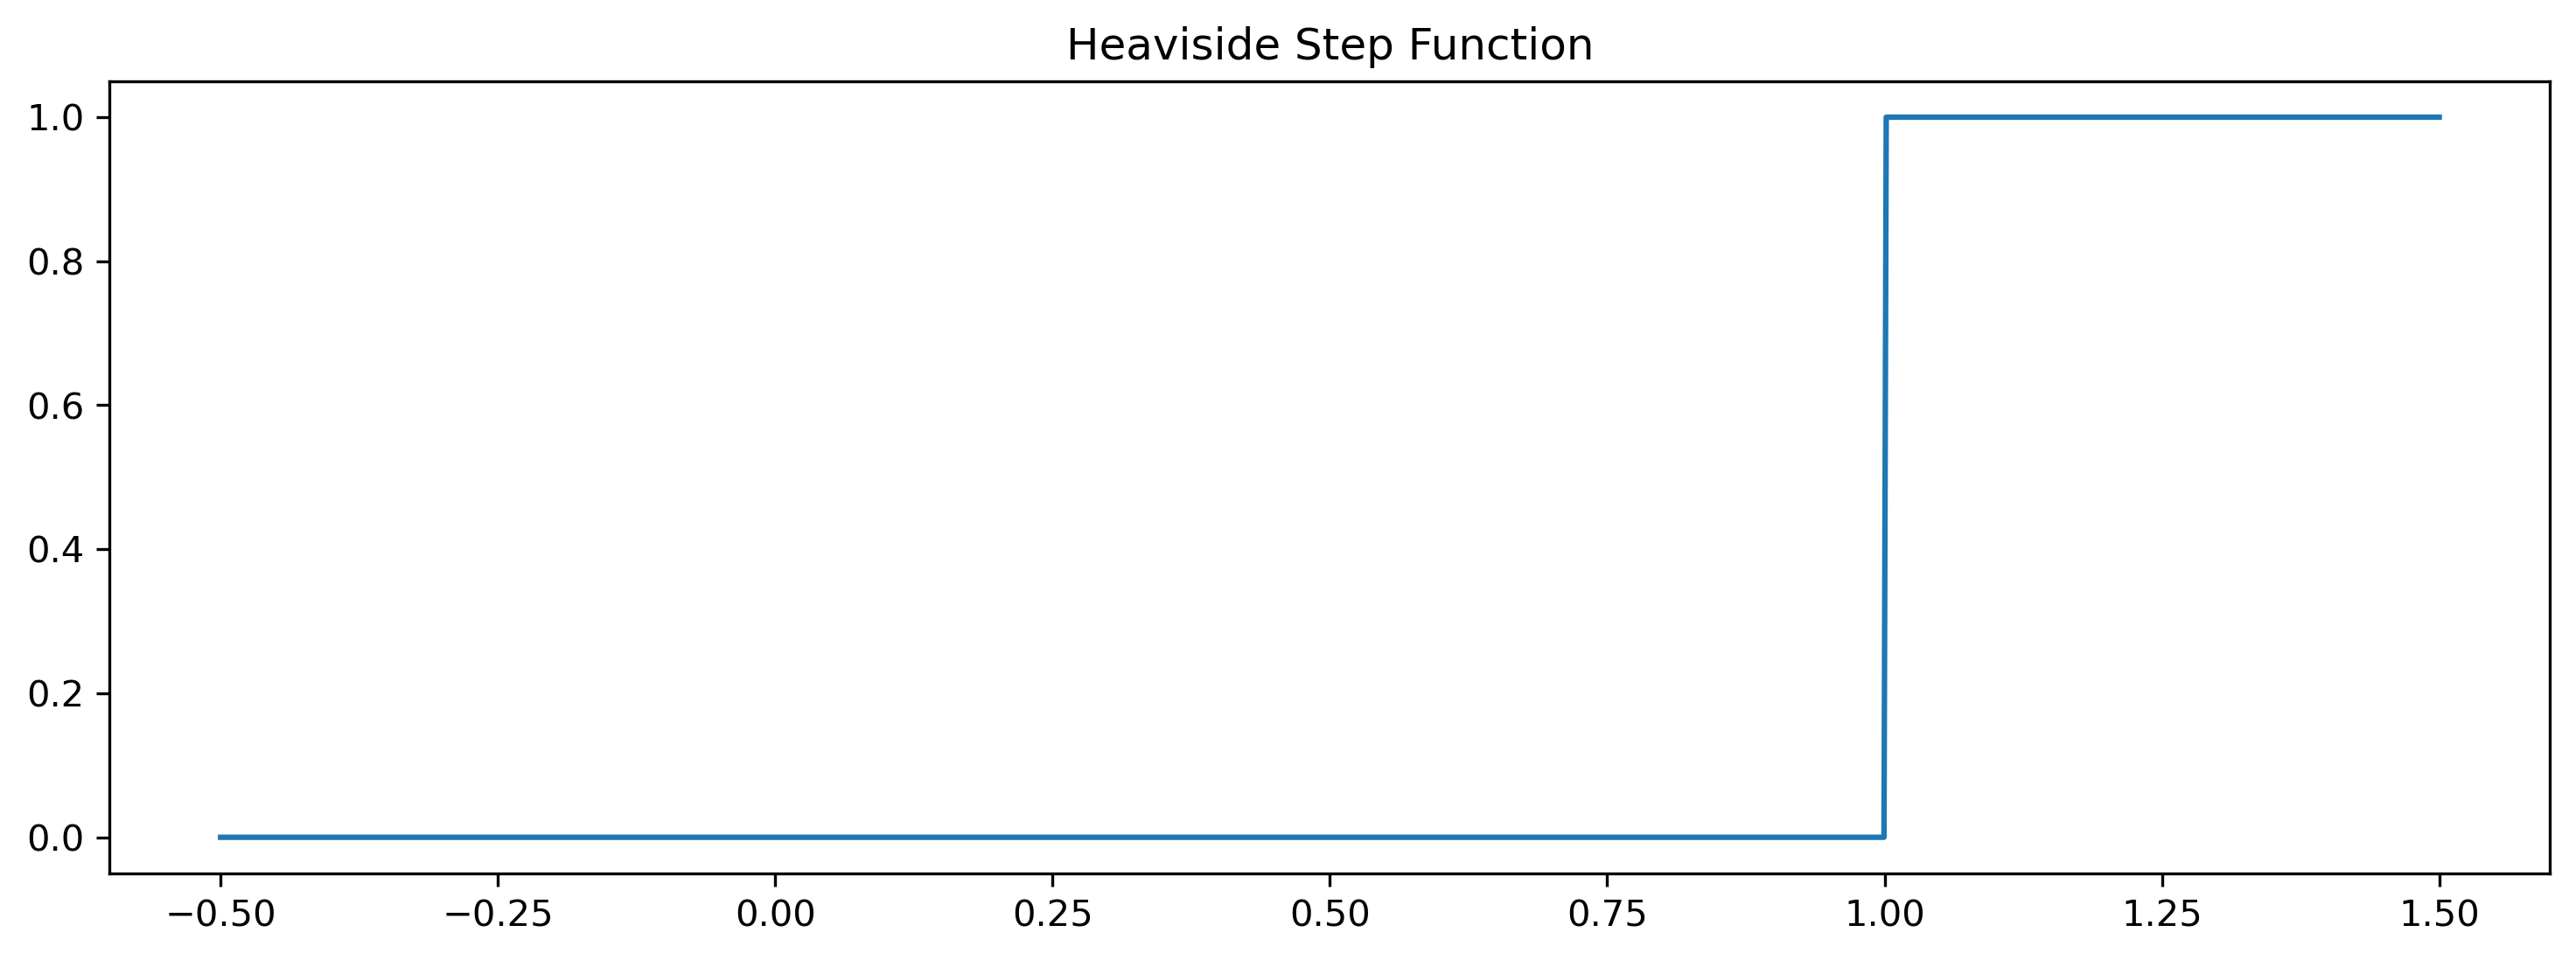

In [13]:
x = torch.linspace(-0.5, 1.5, 1000, requires_grad=True)

# Function
step_pwl = StepPWL.apply
y = step_pwl(x, torch.tensor(1.0), torch.tensor(1.0), torch.tensor(float("inf")))

# Plot
plt.figure()
plt.plot(x.detach(), y.detach())
plt.title("Heaviside Step Function");

If we compute the gradient of y with respect to x, we would see something different than the gradient of the heaviside step function, that is the gradient of the surrogate neuron's transfer function

In [14]:
# Run this just once!
y.backward(x)

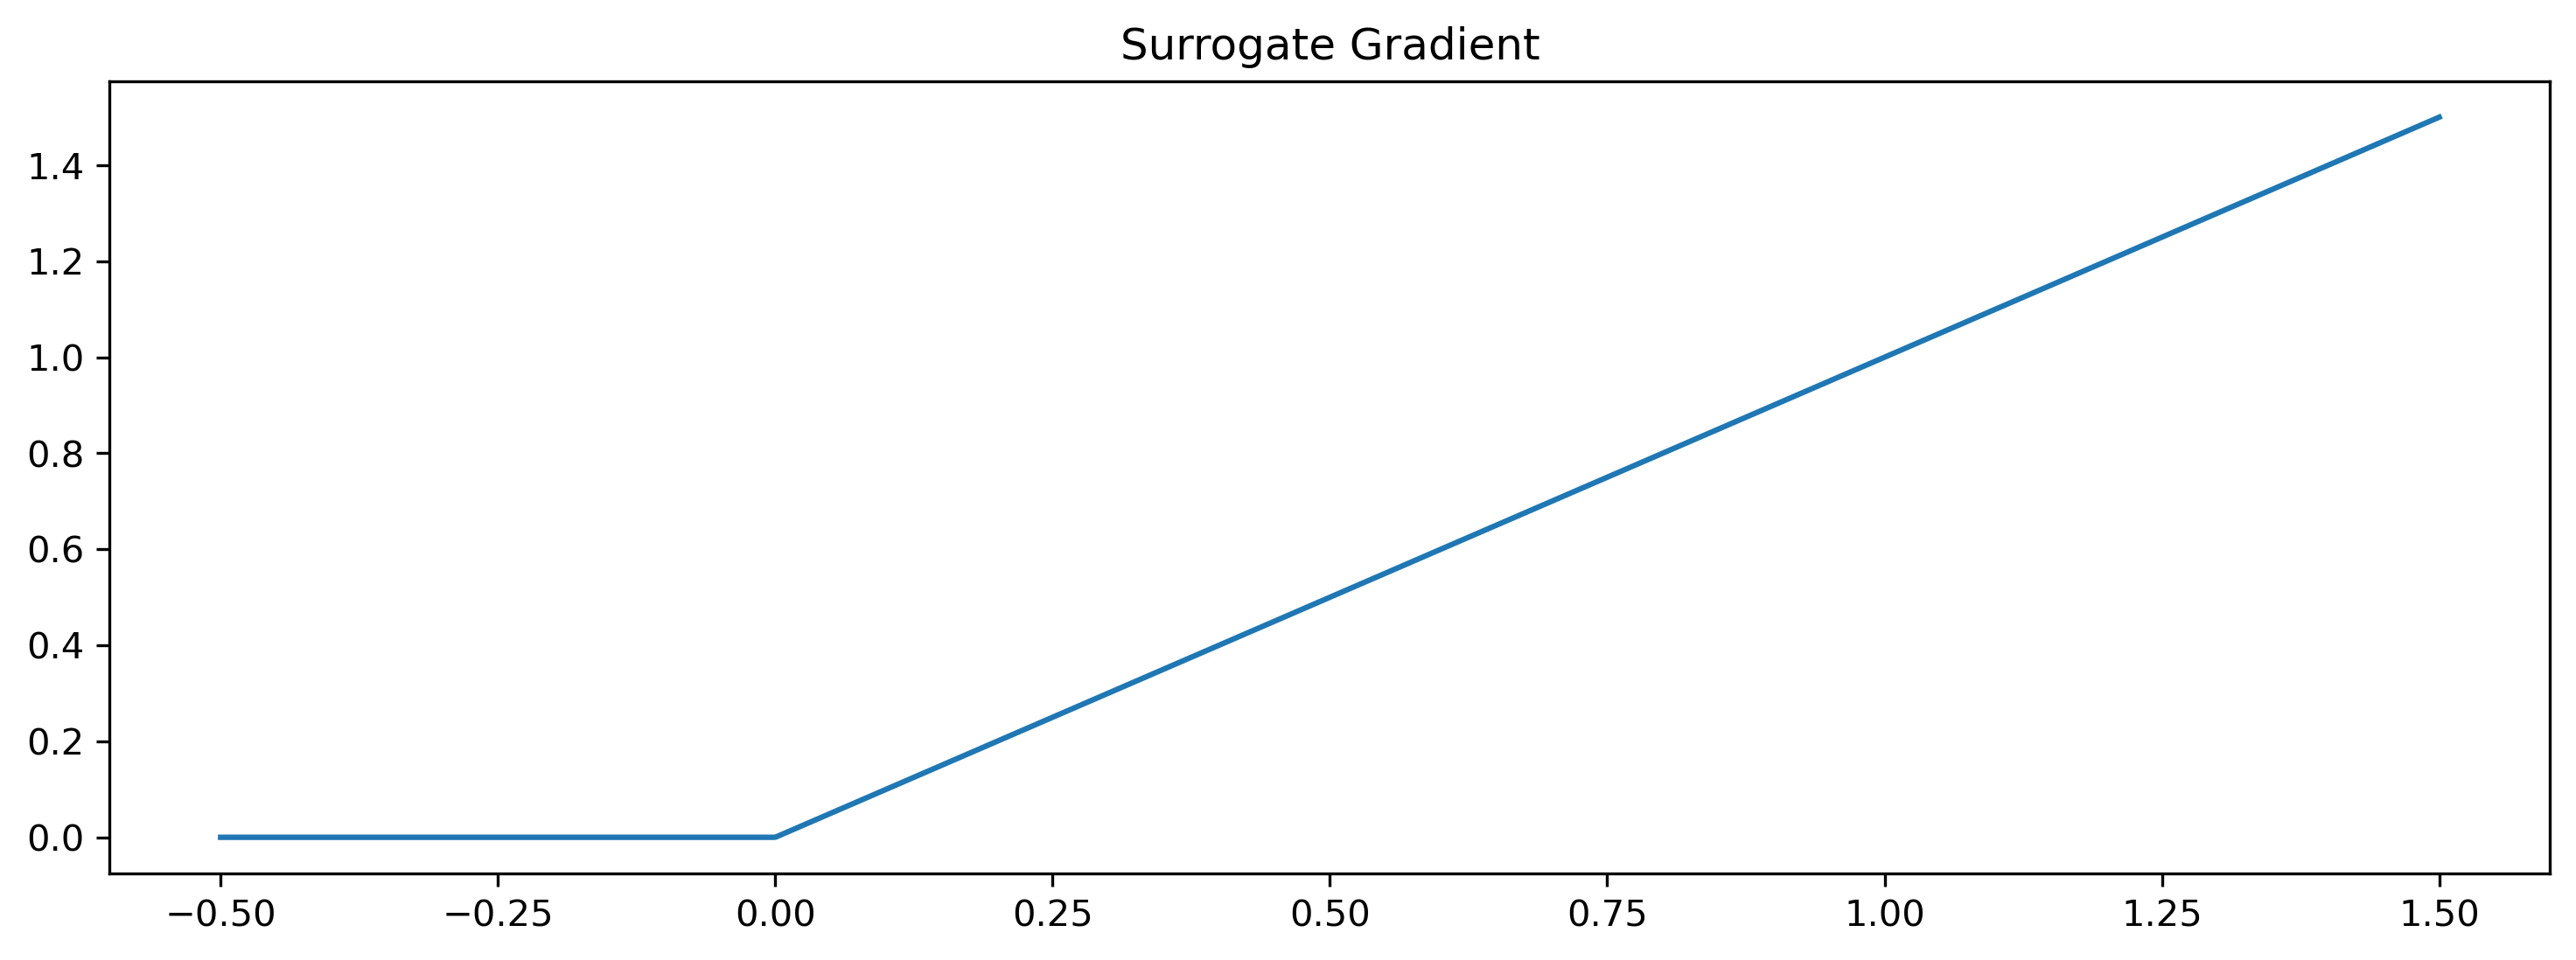

In [15]:
plt.figure()
plt.plot(x.detach(), x.grad.detach())
plt.title("Surrogate Gradient");

To observe the surrogate neuron's transfer function, we can integrate the gradient calculated.

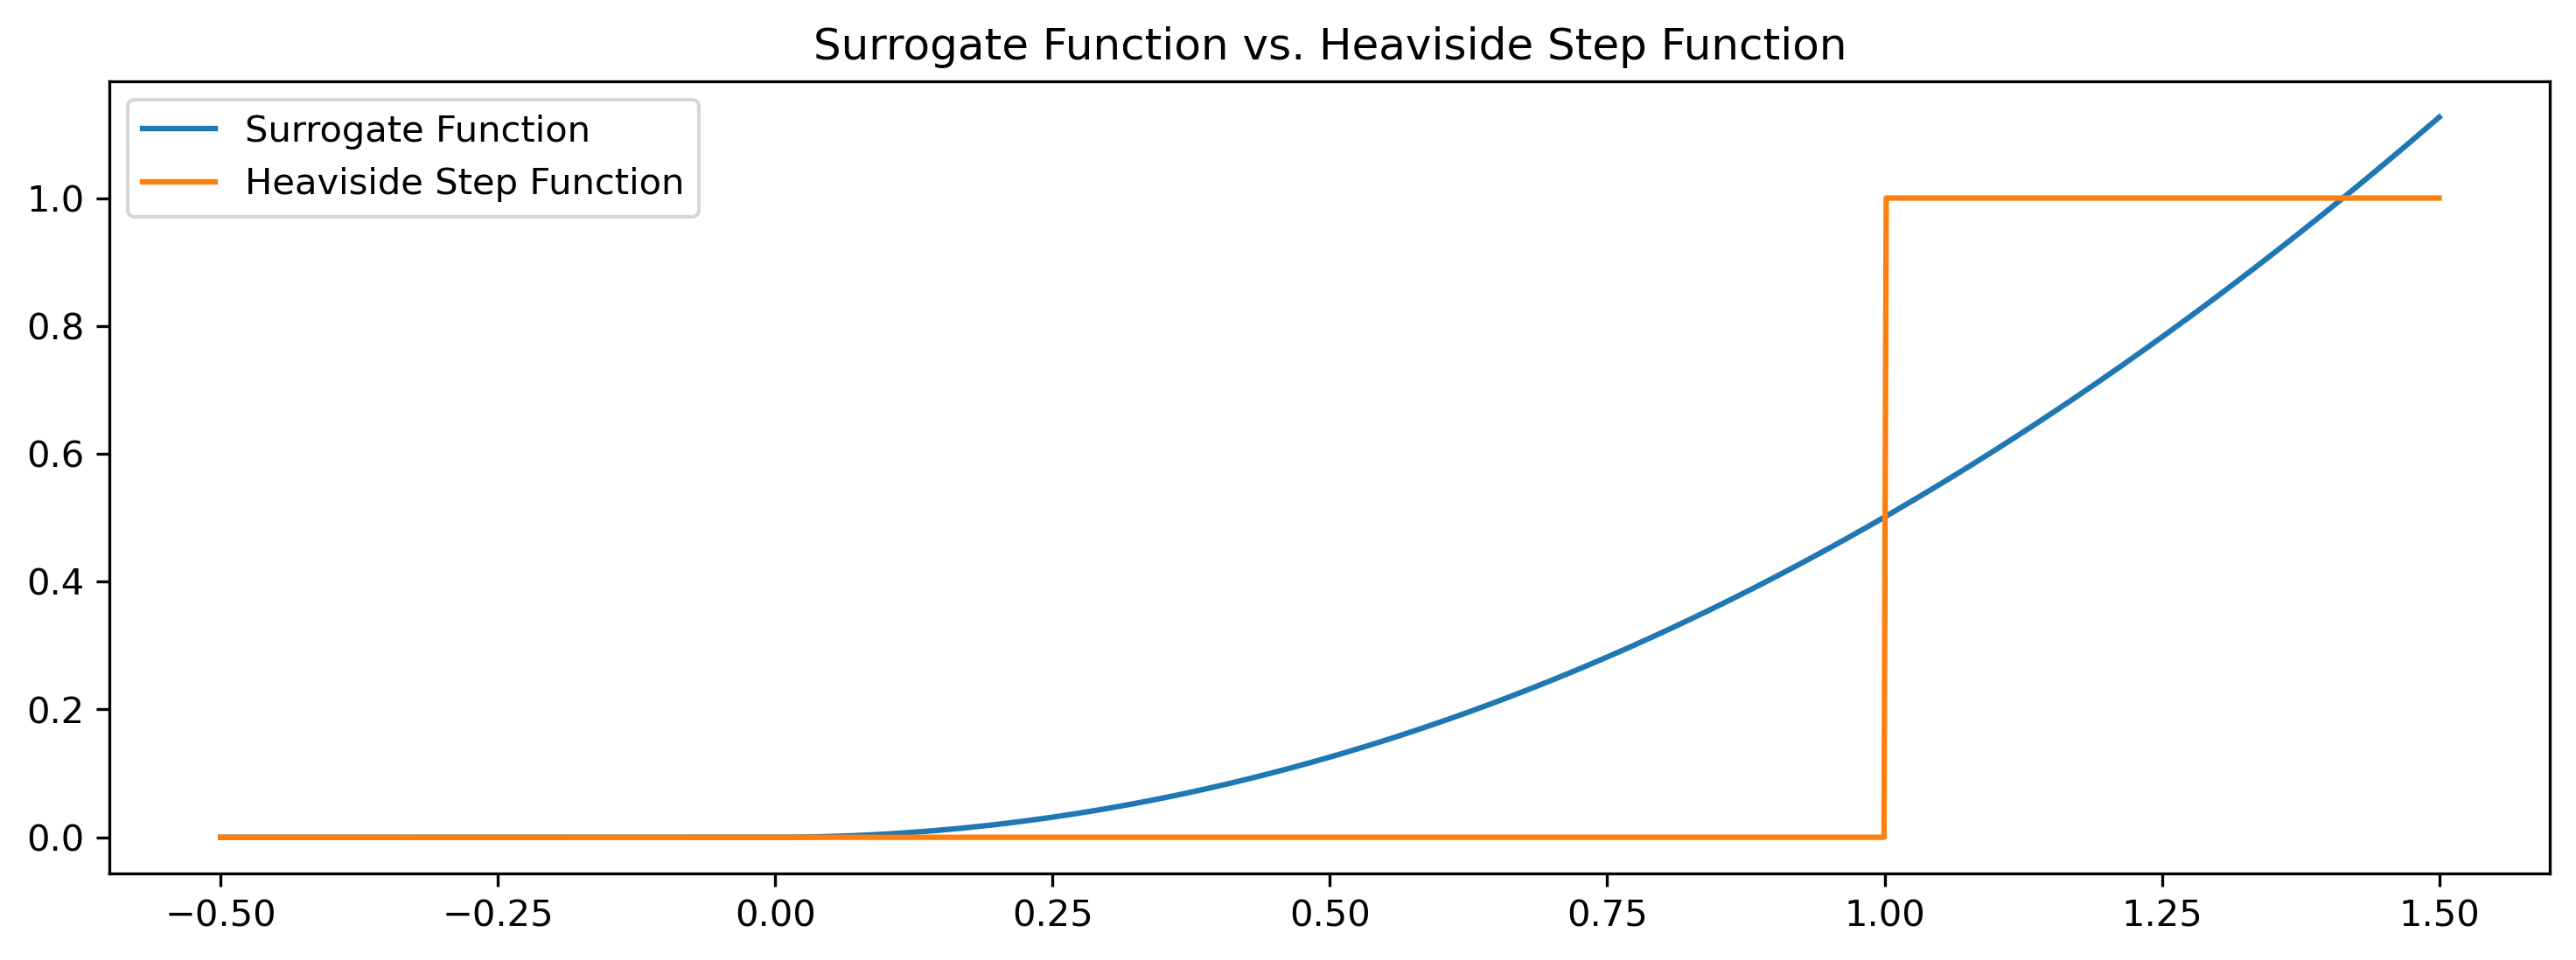

In [16]:
surrogate = np.cumsum(x.grad.detach().flatten()*(x[1]-x[0]).detach().item())
plt.plot(x.detach(), surrogate, label = "Surrogate Function")
plt.plot(x.detach(), y.detach(), label = "Heaviside Step Function")
plt.title("Surrogate Function vs. Heaviside Step Function")
plt.legend();

If we look at the loss surface of the surrogate neuron, we would see that it's differentiable! It provides us with the opportunity that we can apply gradient based optimization to the problem, and obtain the minimum loss.

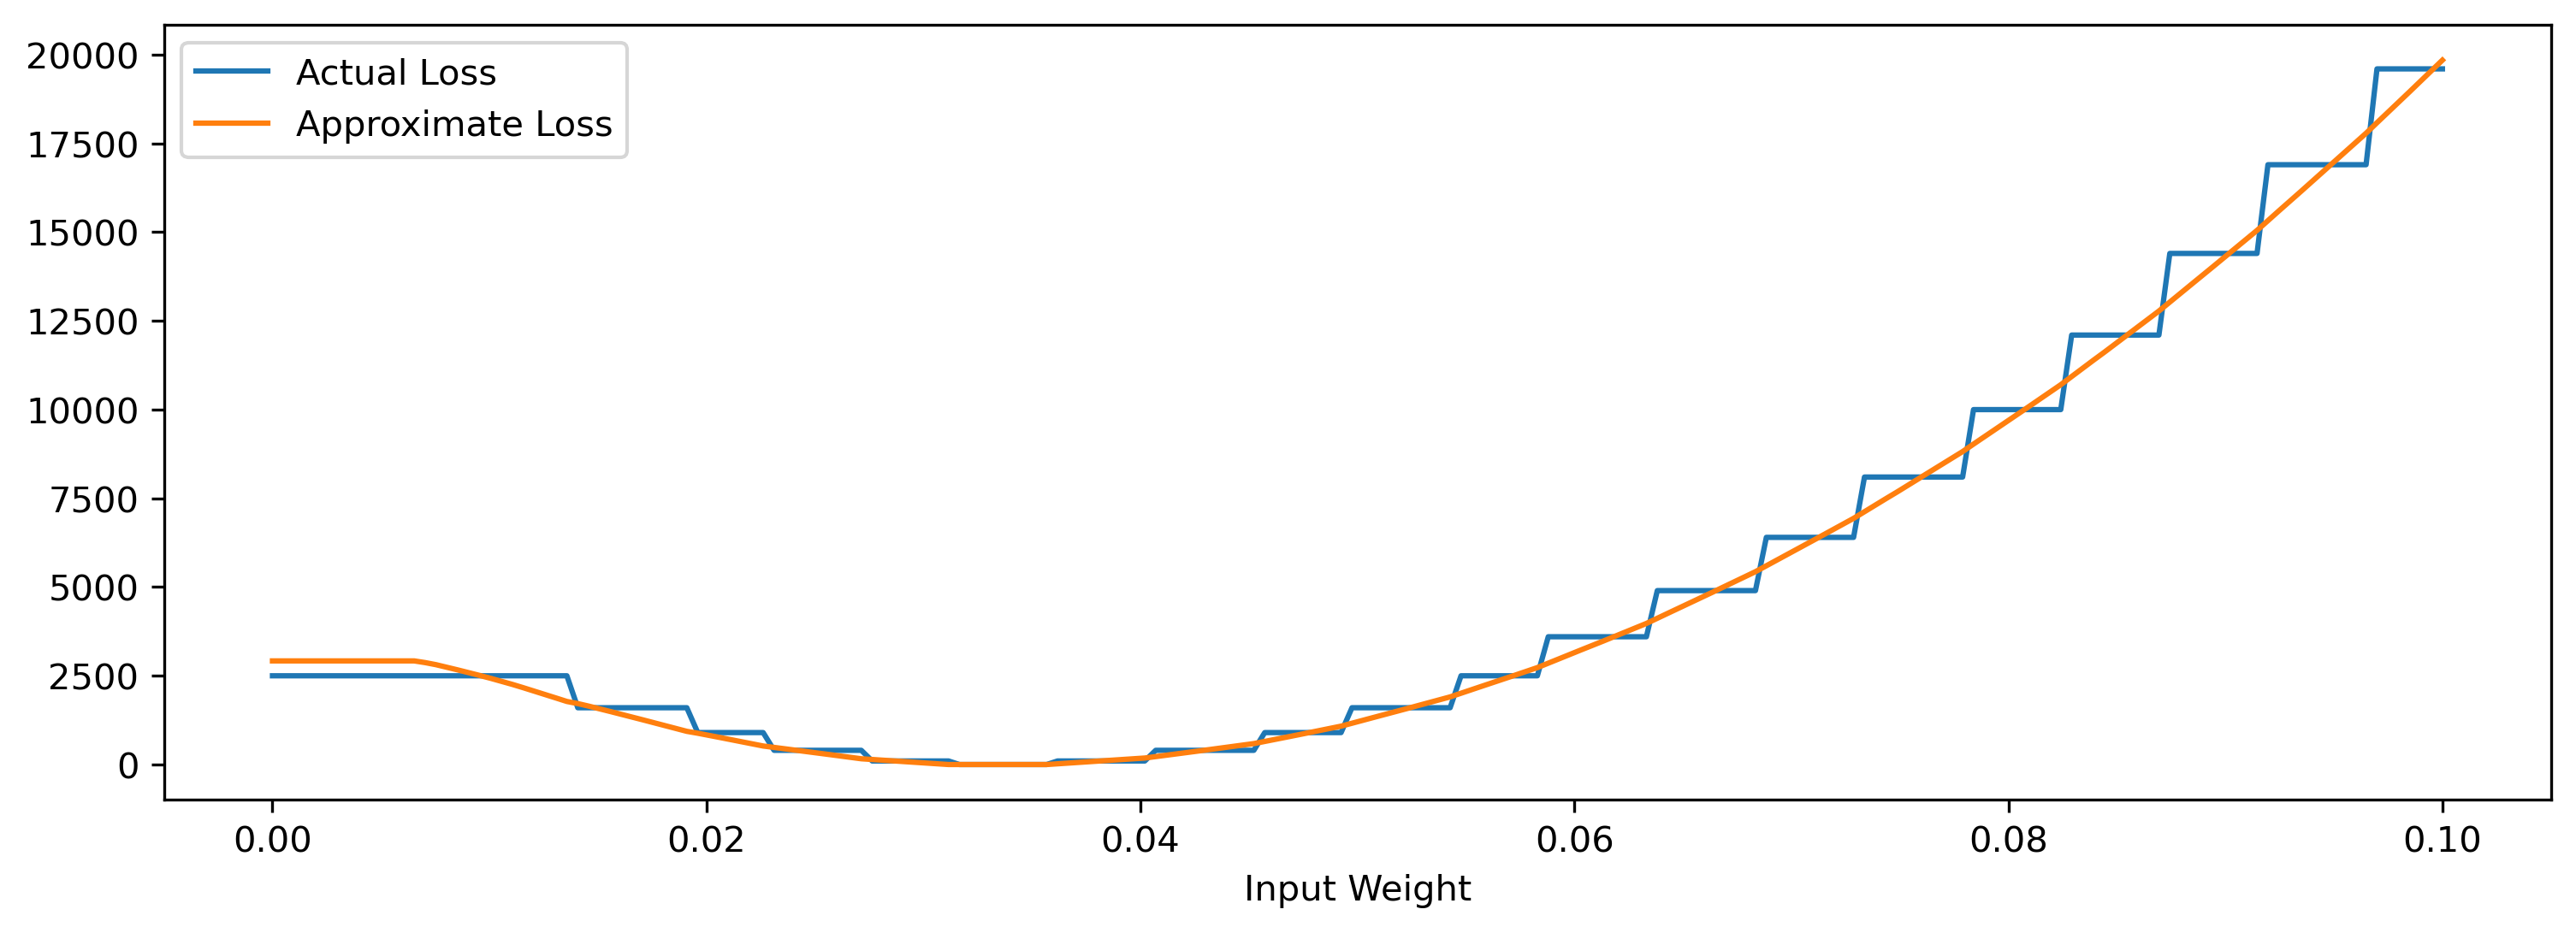

In [17]:
surrogate_loss = np.cumsum(np.array(grad_trace).flatten()*(W[1]-W[0]))
surrogate_loss = surrogate_loss - np.min(surrogate_loss) + np.min(loss_trace)

plt.figure()
plt.plot(W, loss_trace, label = "Actual Loss")
plt.plot(W, surrogate_loss, label = "Approximate Loss")
plt.xlabel("Input Weight");
plt.legend();


## Section 3 : Training a Spiking Neural Network

In [18]:
# Reinitialize the network

dt = 1e-3

# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    weight=torch.tensor([[1.2]]),
    has_bias=False,
)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

In [19]:
crit = MSELoss()
optim = Adam(model.parameters().astorch(), lr=1e-2)
param_trace = []
loss_trace = []
grad_trace = []

for i in tqdm(range(1000)):
    model.reset_state()
    optim.zero_grad()
    out, state, rec = model.evolve(spike_ts, record=True)
    
    # Calculate rate here
    loss = crit(target, out)
    loss_trace.append(loss.item())
    
    if loss == 0:
        break
        
    loss.backward()
    optim.step()
    
    param_trace.append(model._modules['0_LinearTorch'].weight.data[0, 0].item())
    grad_trace.append(model._modules['0_LinearTorch'].weight.grad[0, 0].item())

 30%|███       | 305/1000 [00:13<00:30, 22.42it/s]


## Section 4 : Analyzing the Results

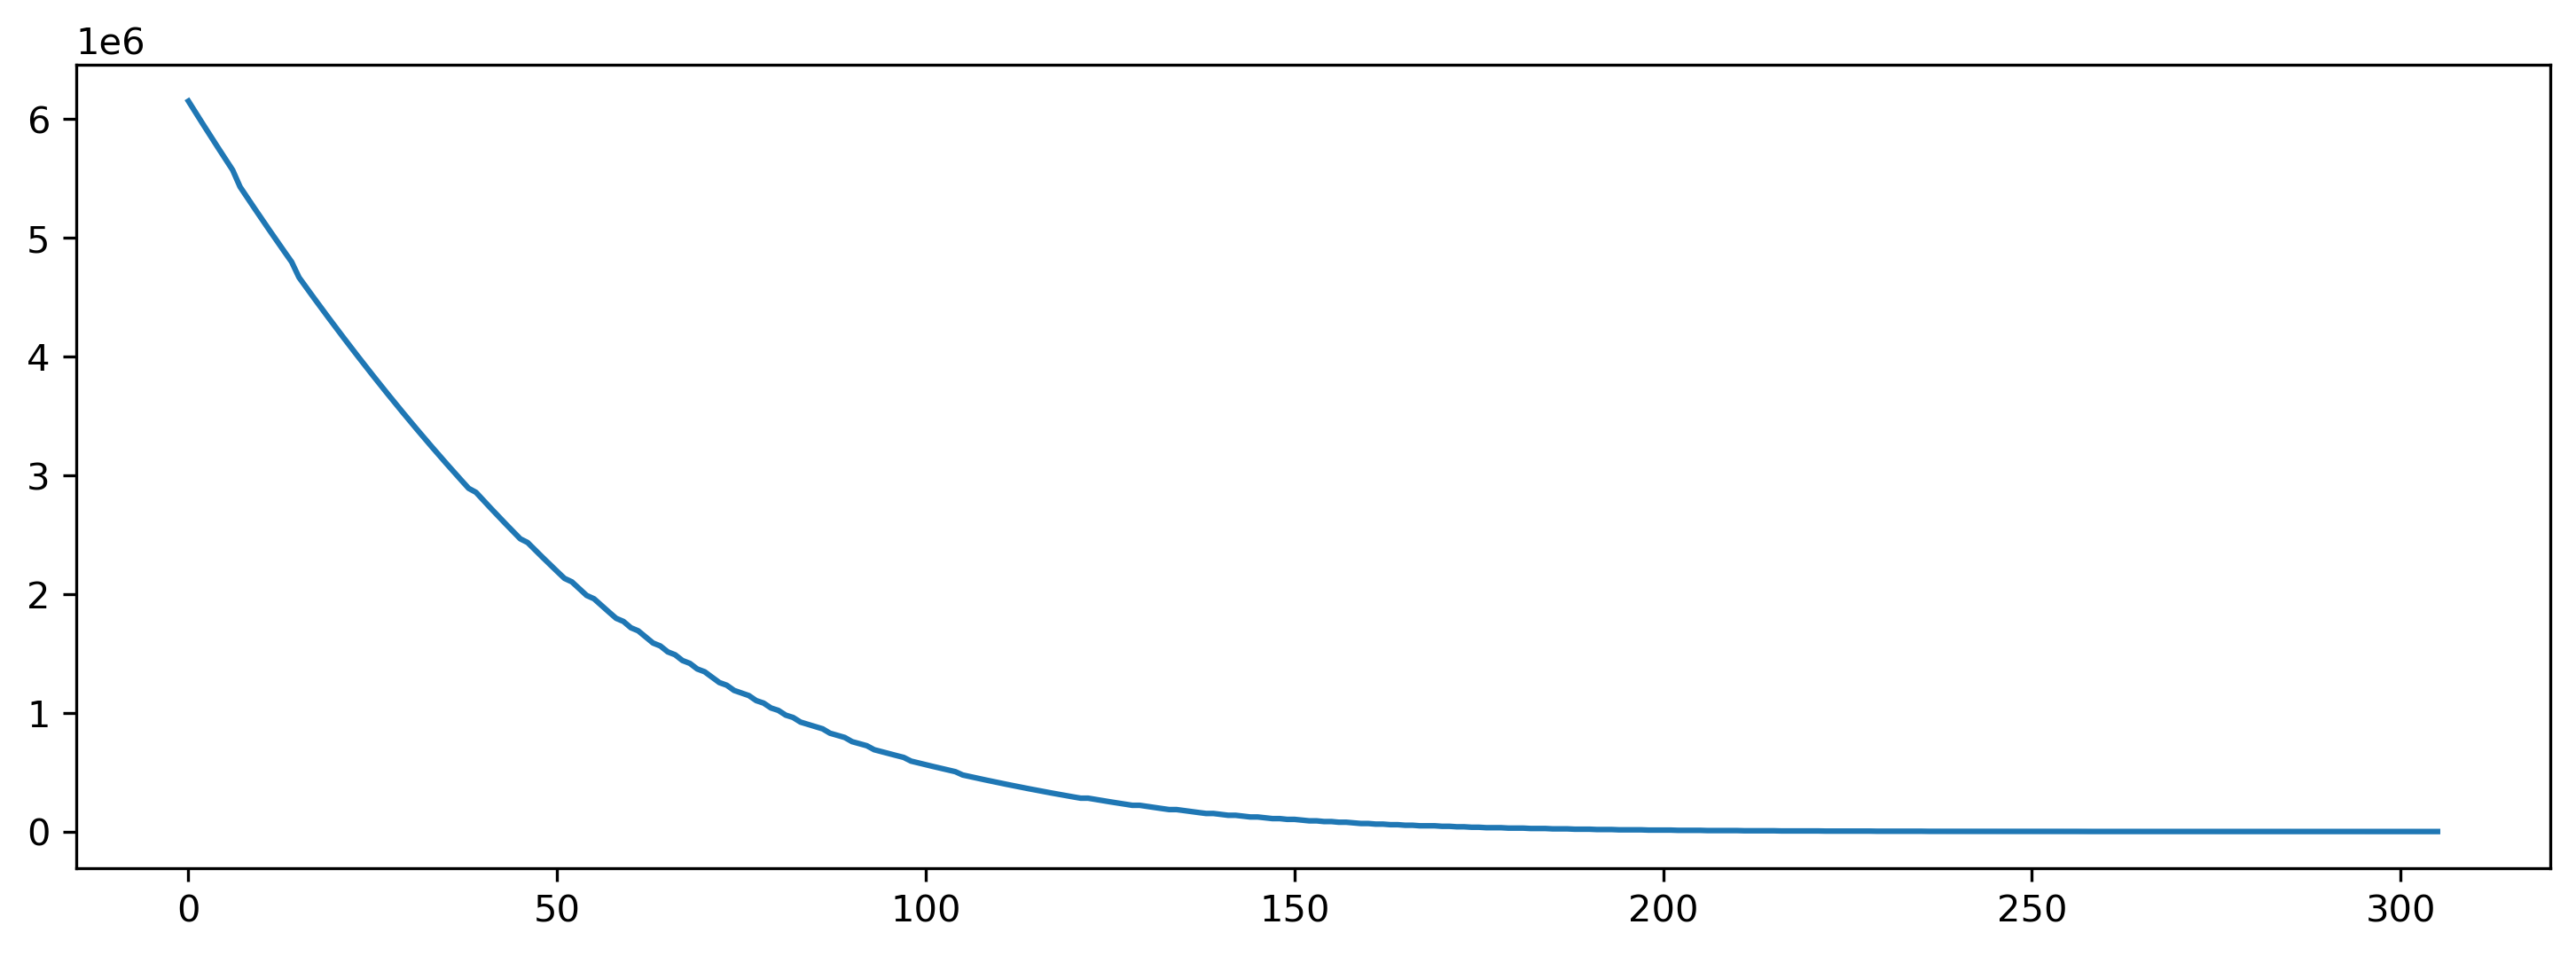

In [20]:
plt.plot(loss_trace)

In [21]:
model.reset_state()
out, state, rec = model(spike_ts, record=True)

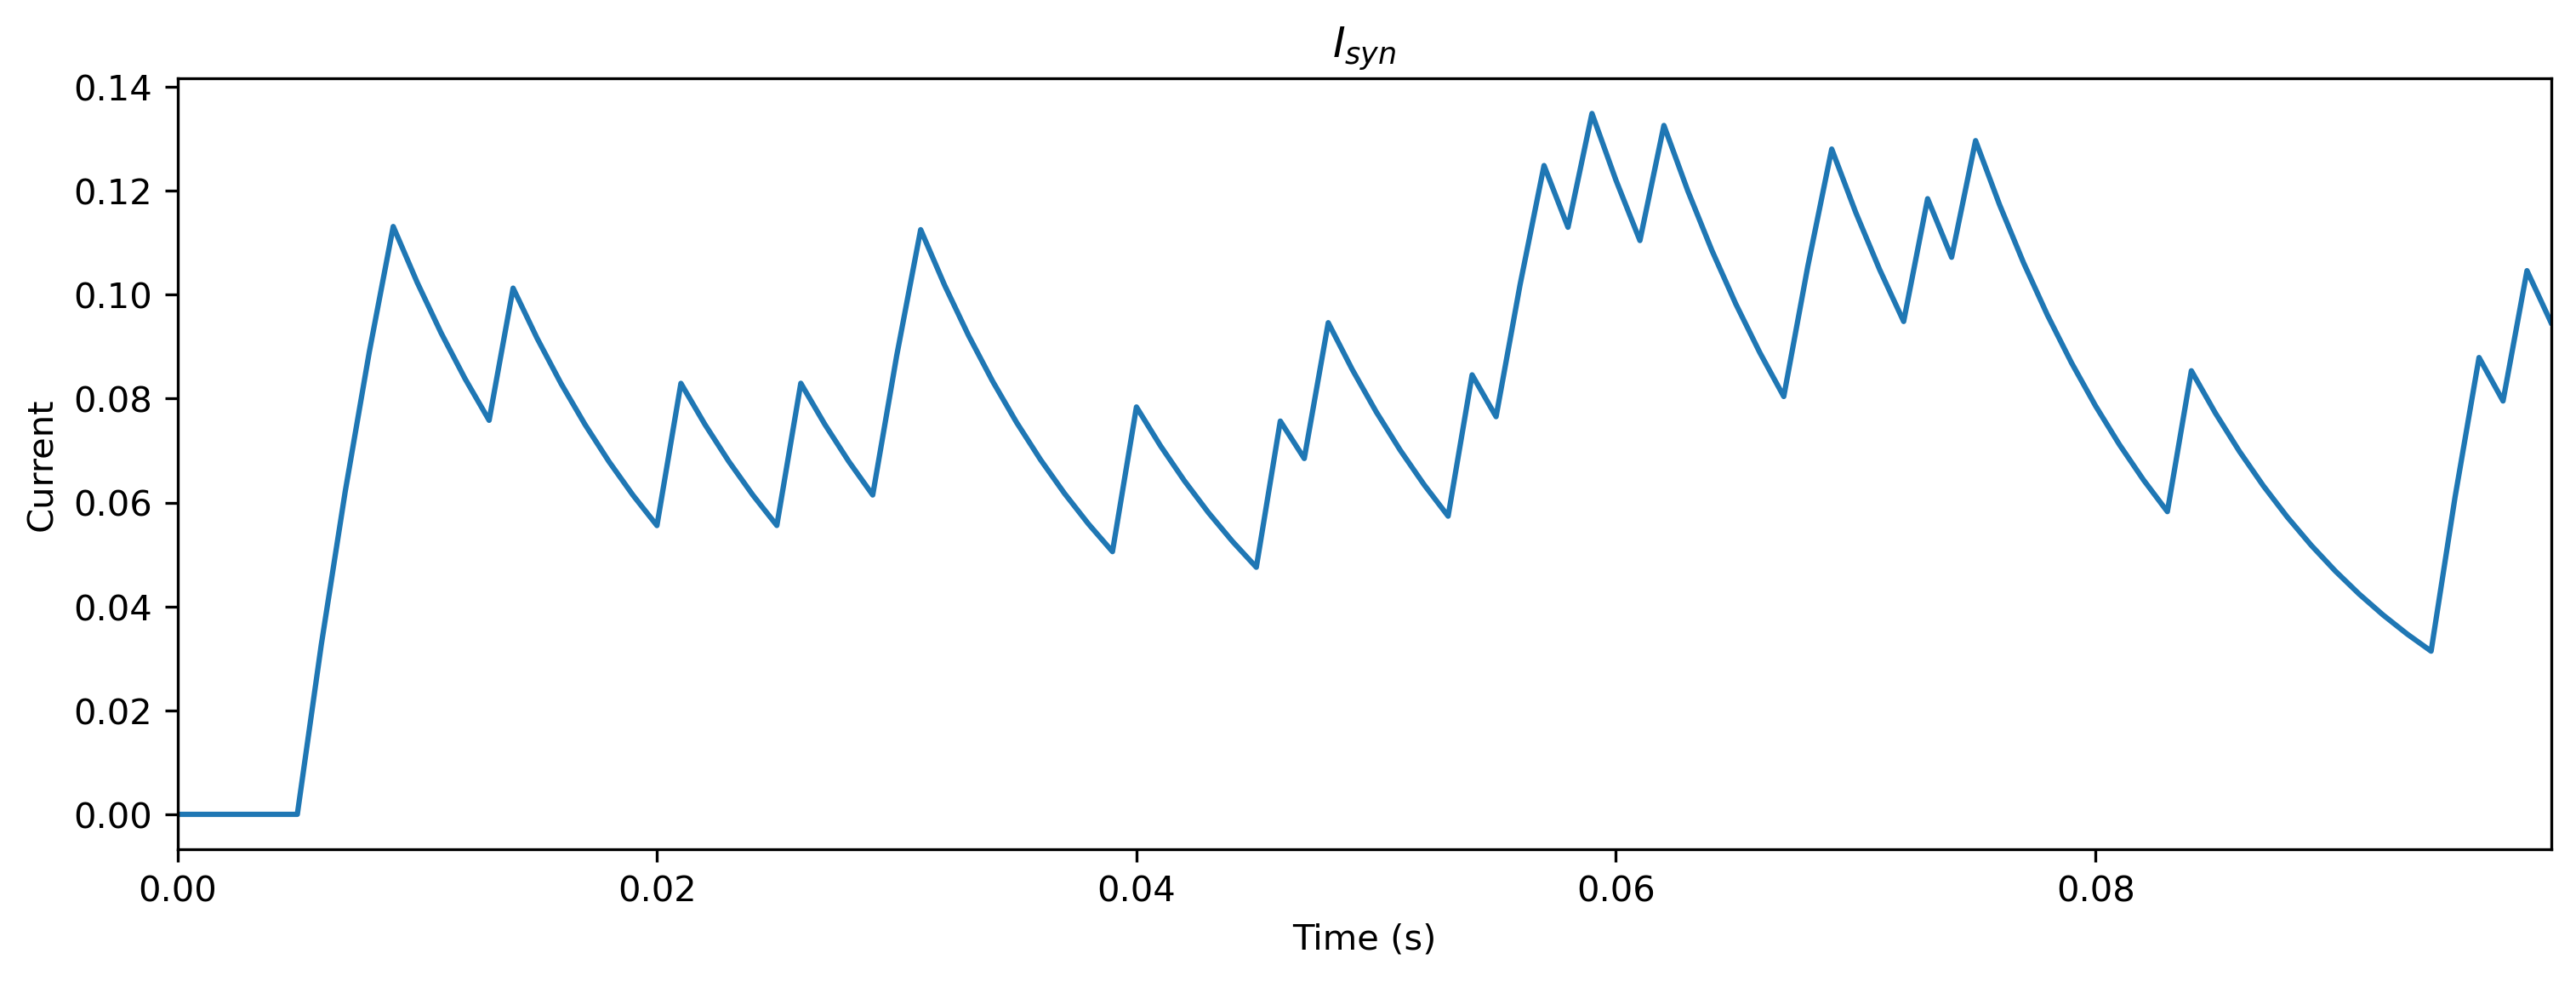

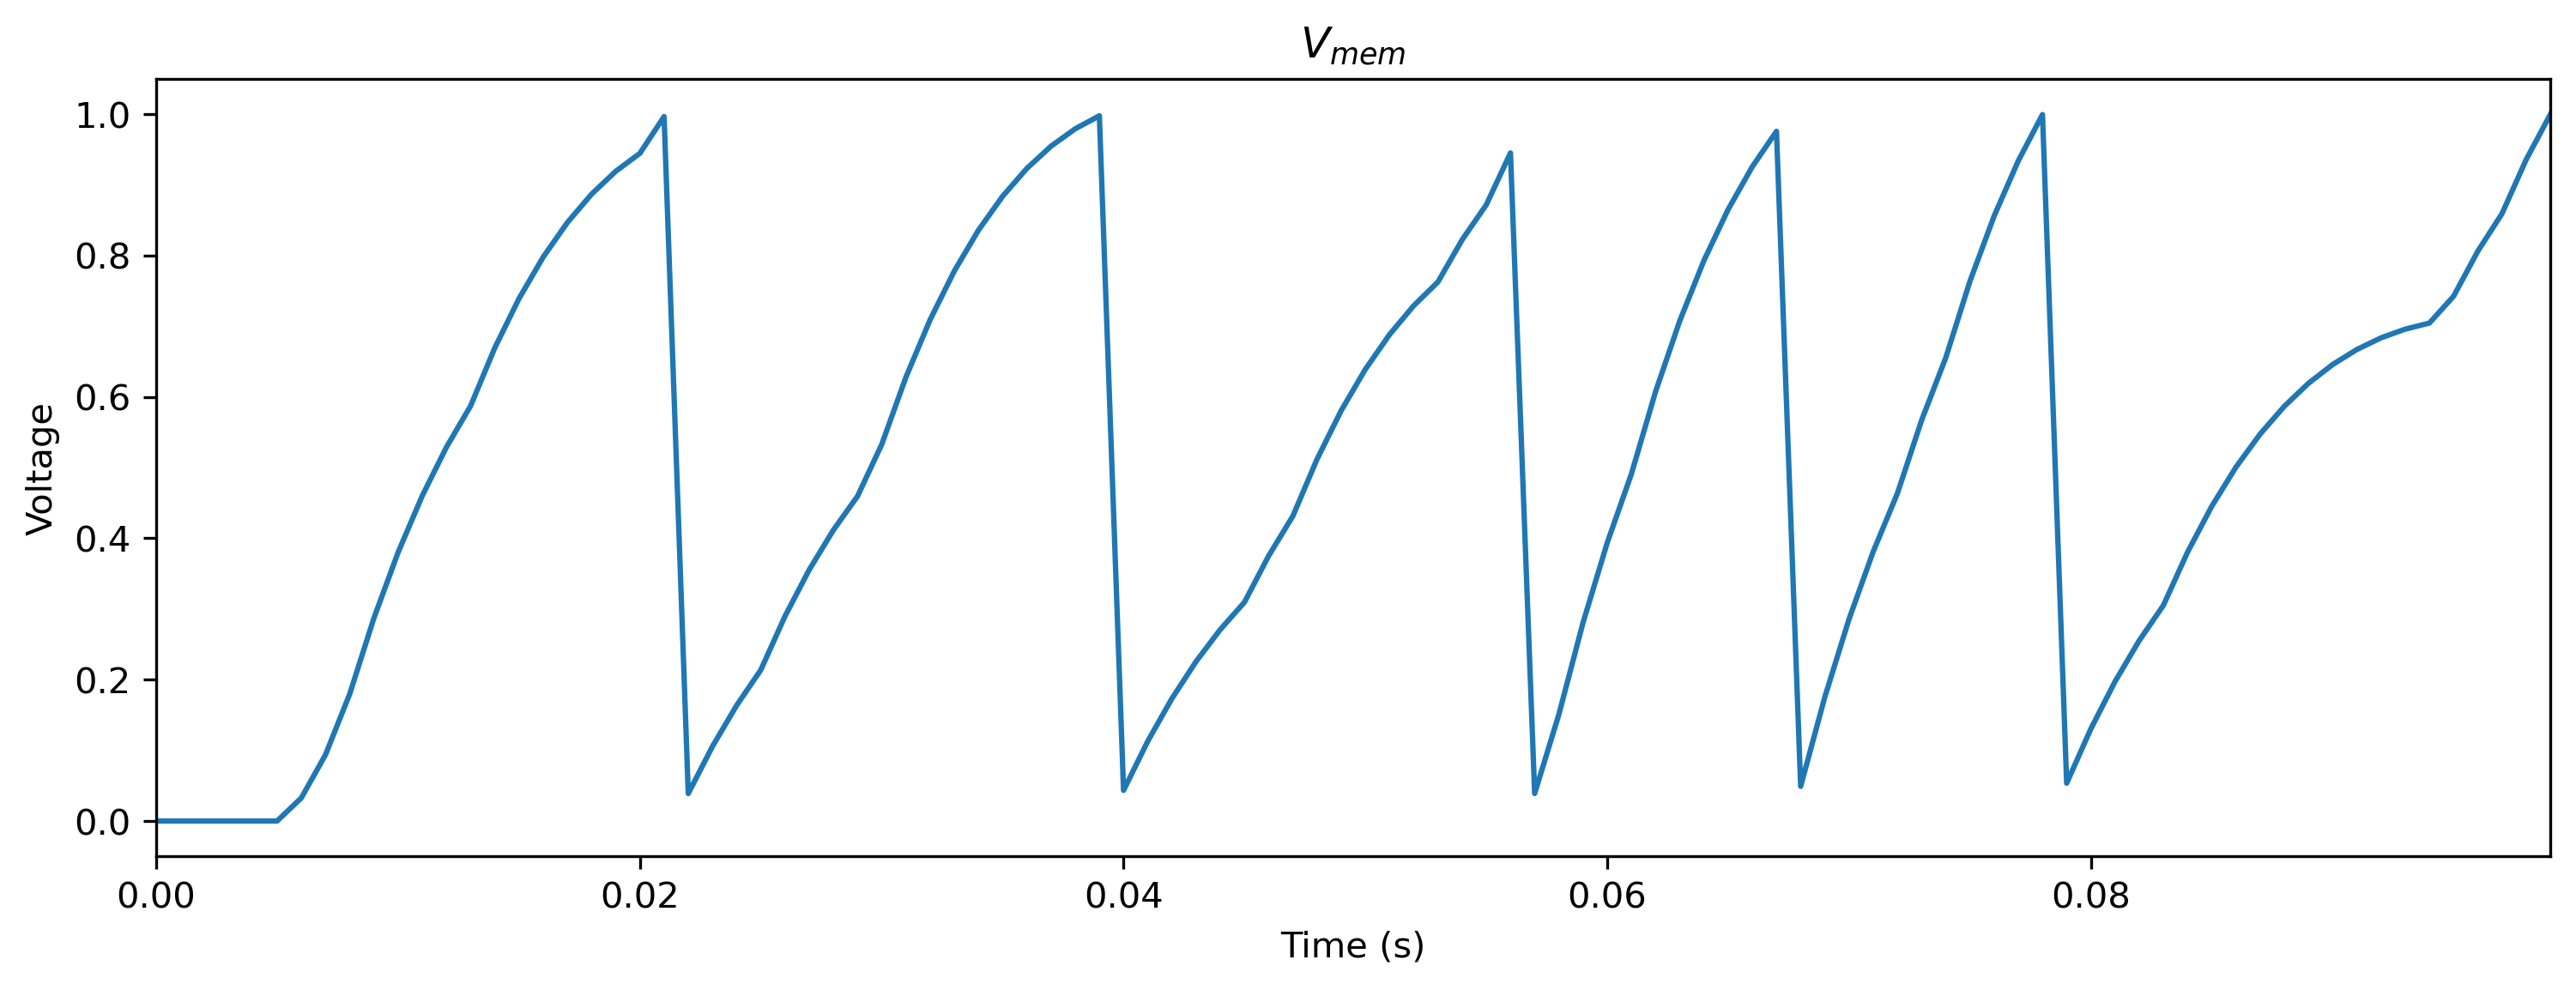

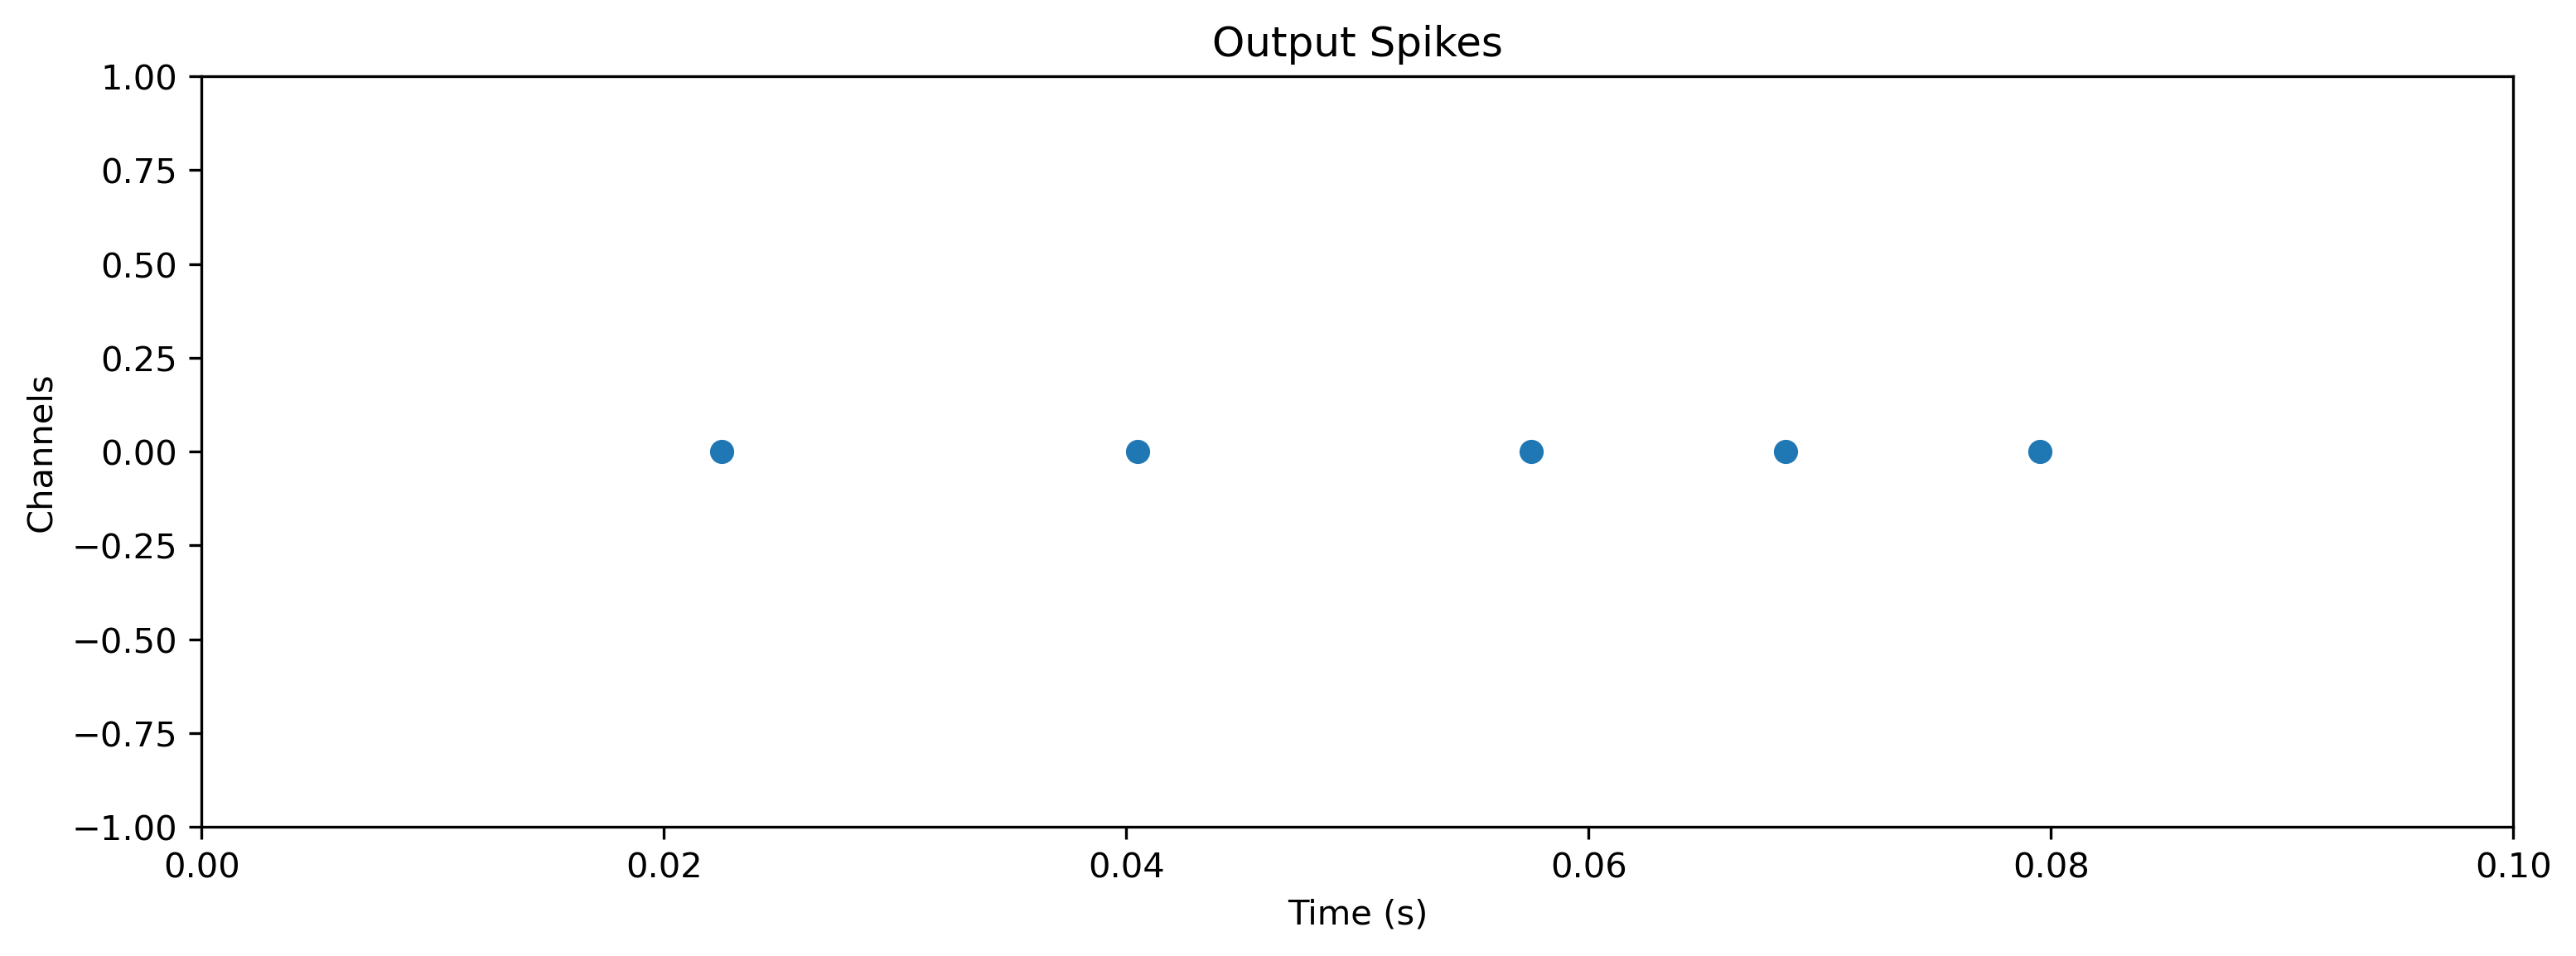

In [22]:
plot_LIF_record(rec['1_LIFTorch'])